LHS 1140 has some data, very faint and Lya detection may be marginal

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from astropy.table import Table
from astropy.io import ascii
from astropy.convolution import convolve, Box1DKernel
from scipy.interpolate import interp1d
from scipy.io import readsav


import astropy.units as u
from astropy import time, coordinates as coord
import astropy.constants as const
from astropy.modeling import models, fitting
from astropy.coordinates import SkyCoord
from matplotlib.gridspec import GridSpec
from datetime import datetime
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from astropy.io.votable import parse


#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

In [21]:
path = '/media/david/2tb_ext_hd/hddata/meats/hst/lhs_1140/stis/'

In [22]:
x1ds = glob.glob('{}*x1d.fits'.format(path))
x1ds

['/media/david/2tb_ext_hd/hddata/meats/hst/lhs_1140/stis/ode406010_x1d.fits',
 '/media/david/2tb_ext_hd/hddata/meats/hst/lhs_1140/stis/odmw01010_x1d.fits',
 '/media/david/2tb_ext_hd/hddata/meats/hst/lhs_1140/stis/odmw04010_x1d.fits',
 '/media/david/2tb_ext_hd/hddata/meats/hst/lhs_1140/stis/odmw02010_x1d.fits',
 '/media/david/2tb_ext_hd/hddata/meats/hst/lhs_1140/stis/odmw02020_x1d.fits',
 '/media/david/2tb_ext_hd/hddata/meats/hst/lhs_1140/stis/odmw03010_x1d.fits',
 '/media/david/2tb_ext_hd/hddata/meats/hst/lhs_1140/stis/odmw03020_x1d.fits',
 '/media/david/2tb_ext_hd/hddata/meats/hst/lhs_1140/stis/odmw04020_x1d.fits']

/media/david/2tb_ext_hd/hddata/meats/hst/lhs_1140/stis/ode406010_x1d.fits
G140M
556.46924


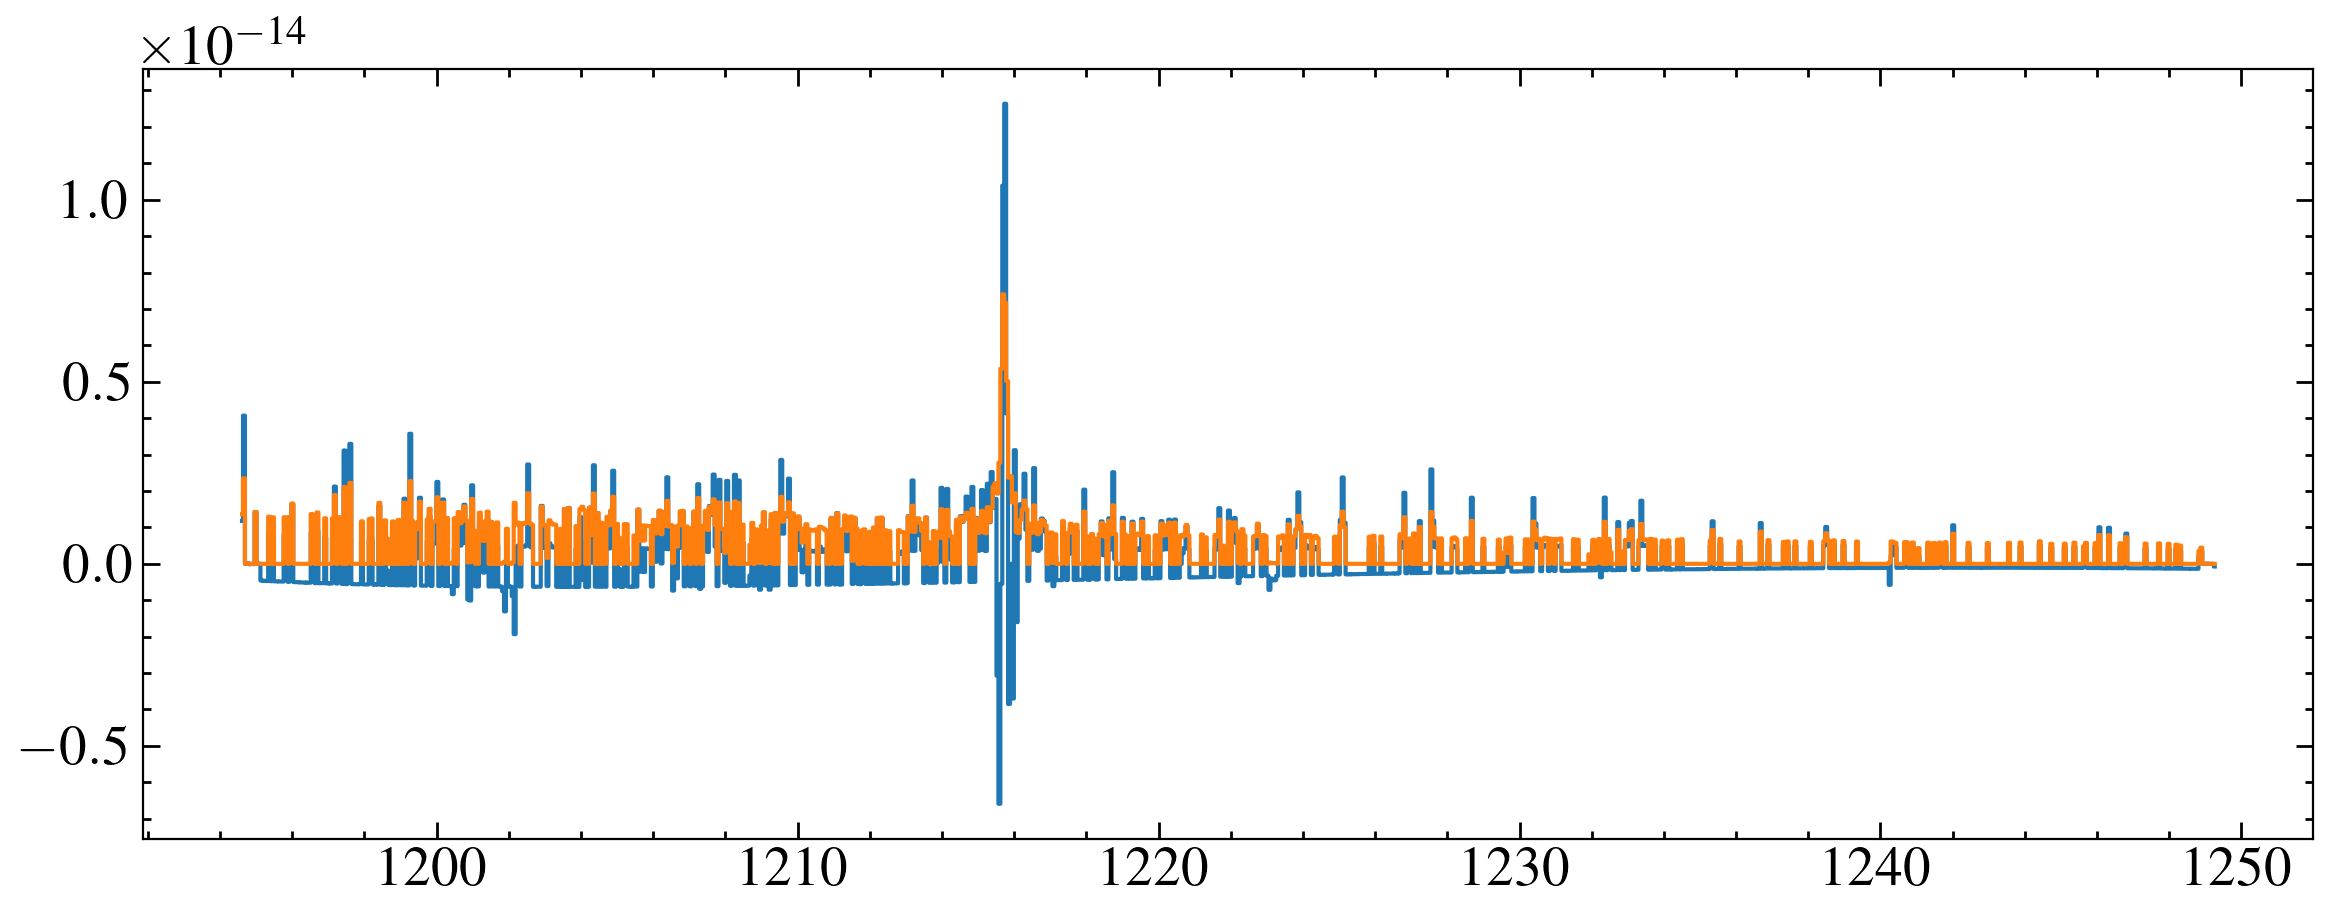

/media/david/2tb_ext_hd/hddata/meats/hst/lhs_1140/stis/odmw01010_x1d.fits
G140M
0.37203524


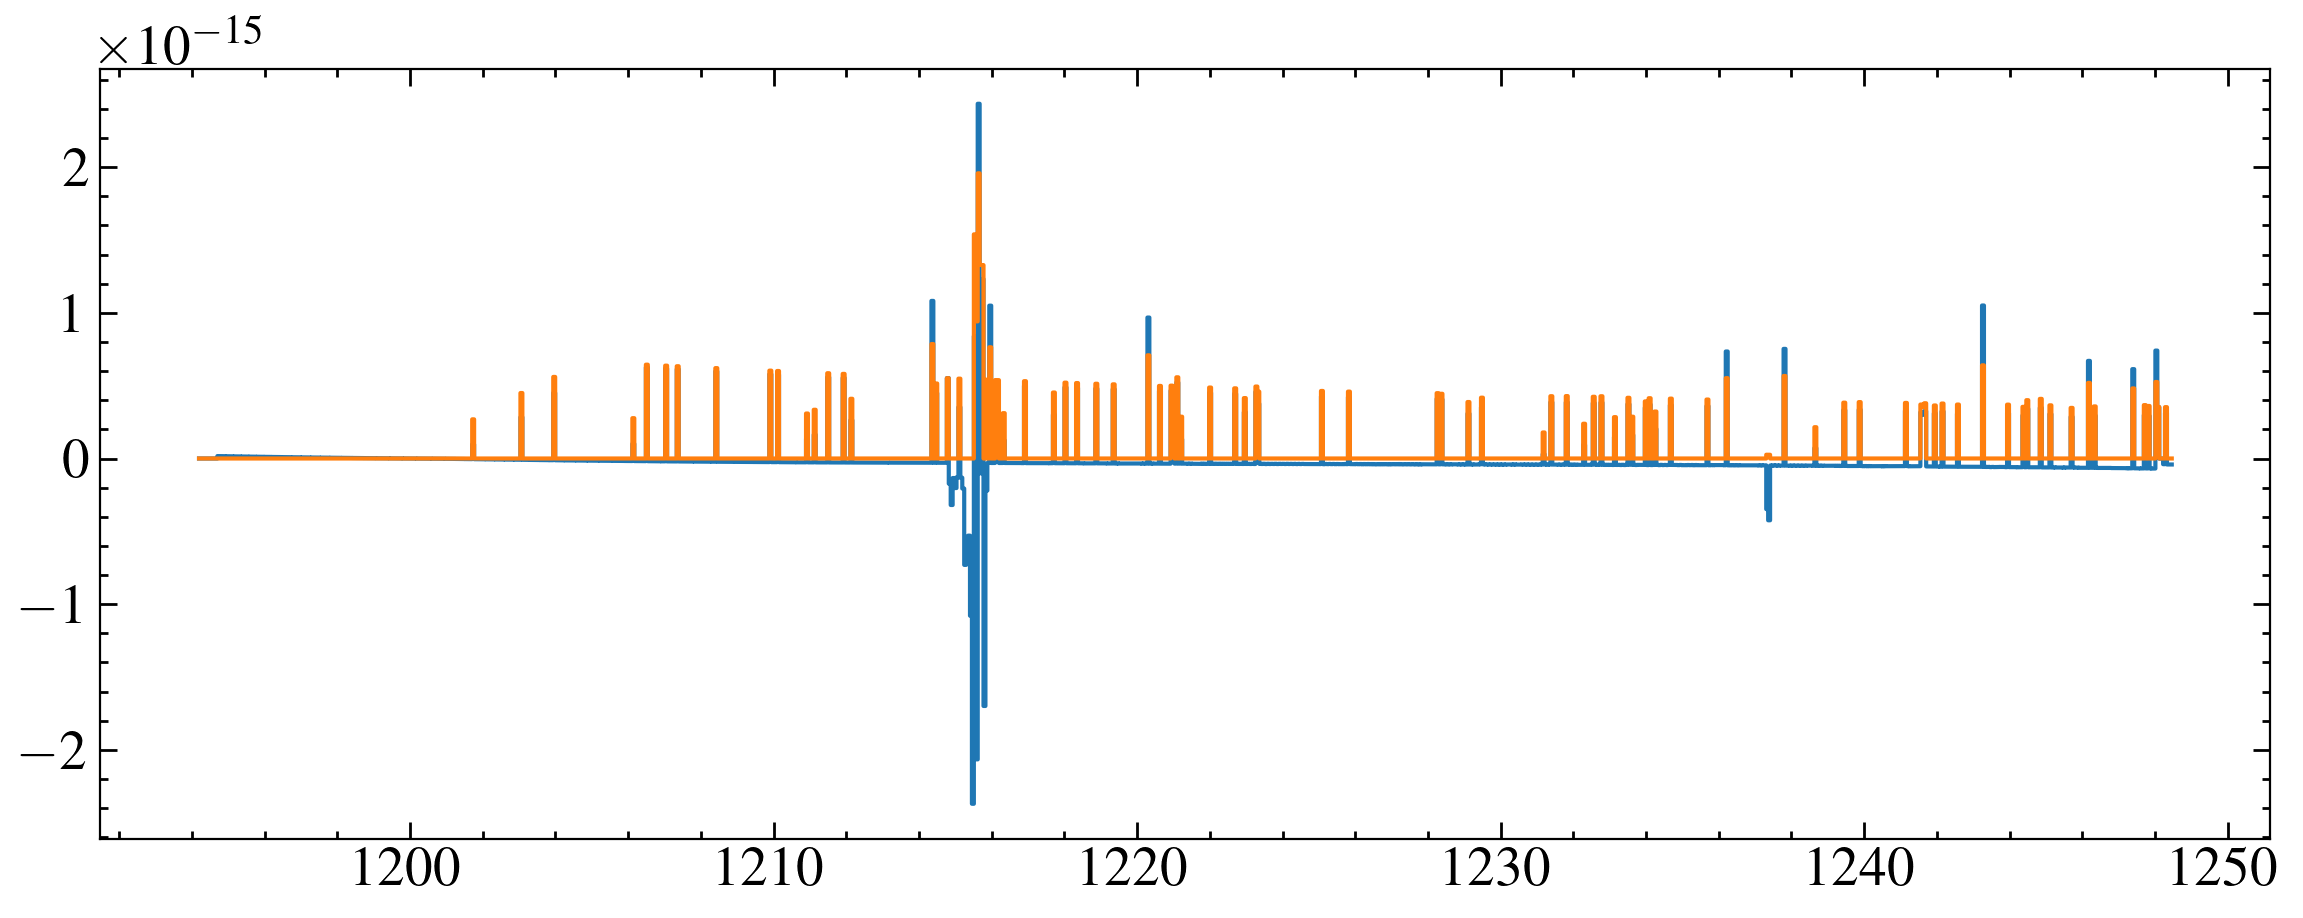

/media/david/2tb_ext_hd/hddata/meats/hst/lhs_1140/stis/odmw04010_x1d.fits
G140M
556.55475


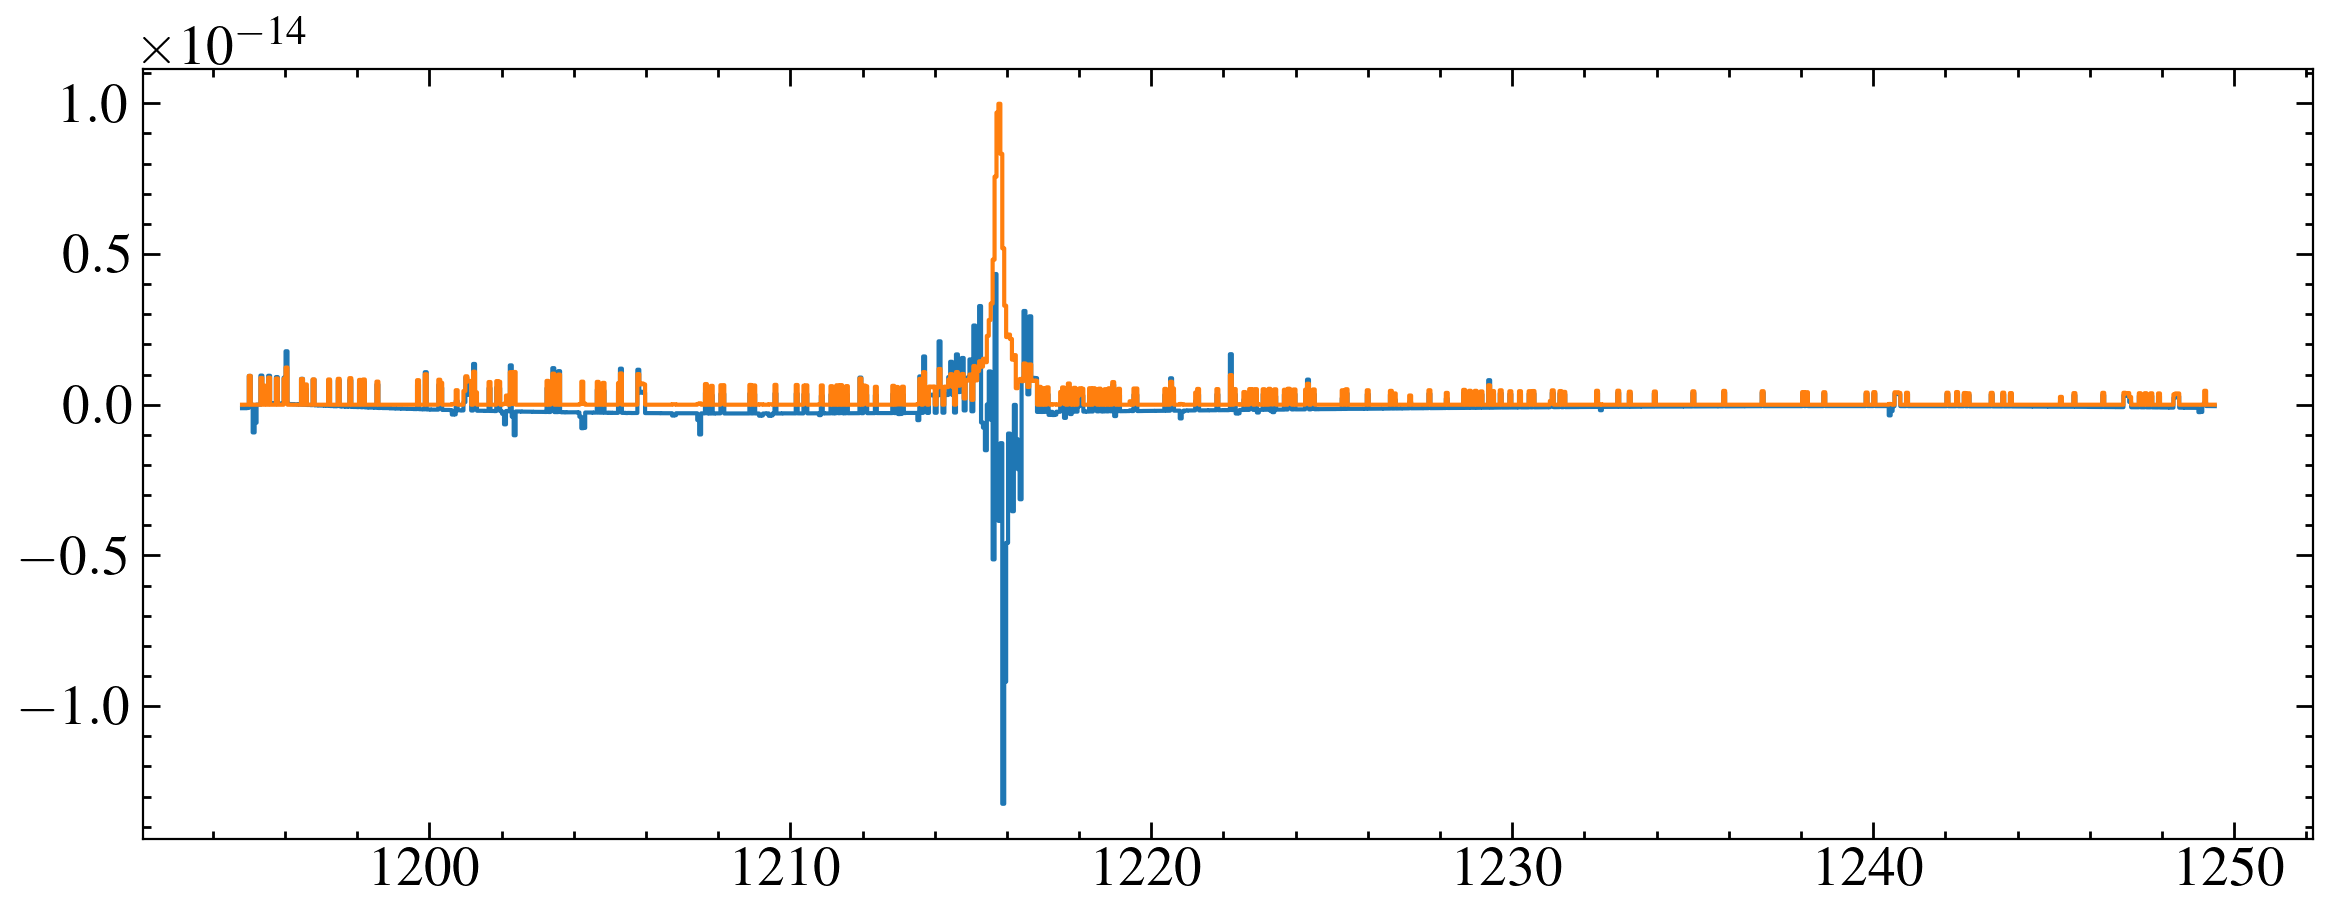

/media/david/2tb_ext_hd/hddata/meats/hst/lhs_1140/stis/odmw02010_x1d.fits
G140M
0.32536379


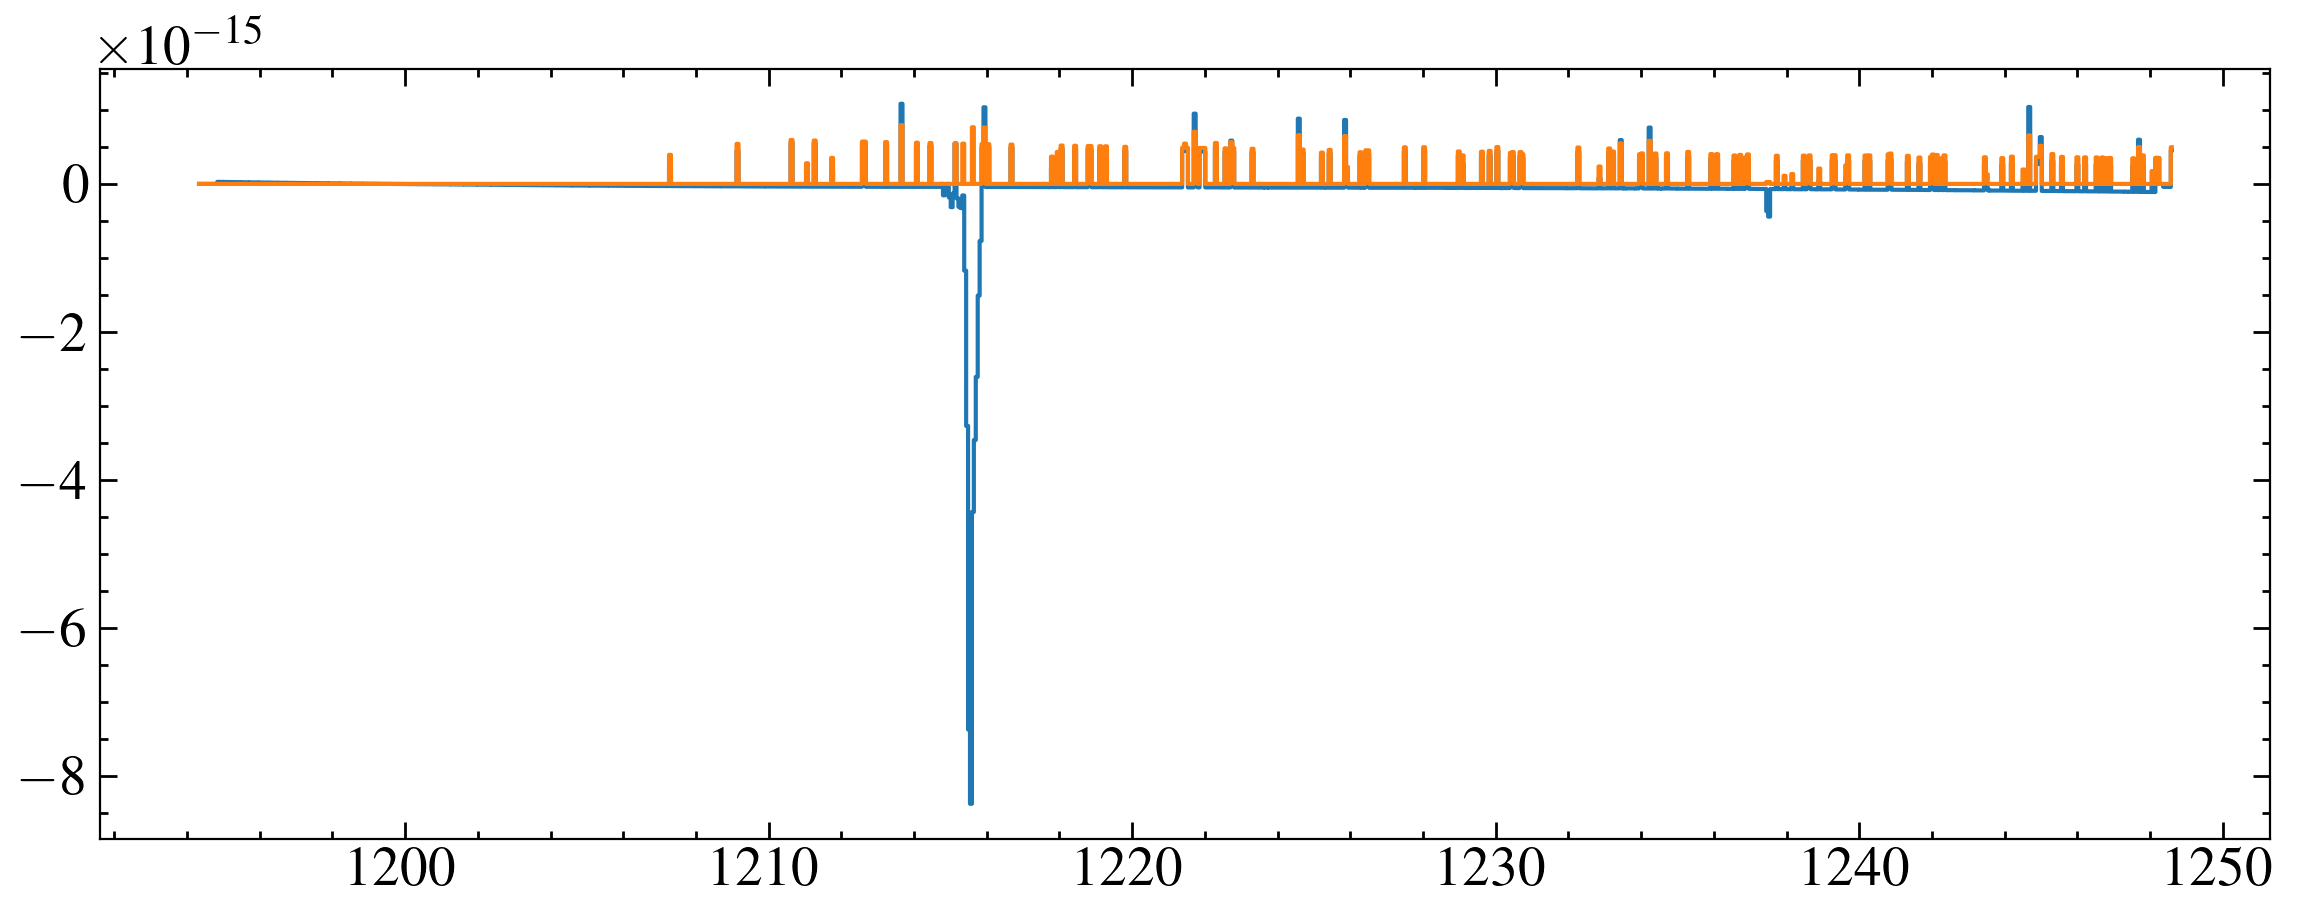

/media/david/2tb_ext_hd/hddata/meats/hst/lhs_1140/stis/odmw02020_x1d.fits
G230L
514.3599


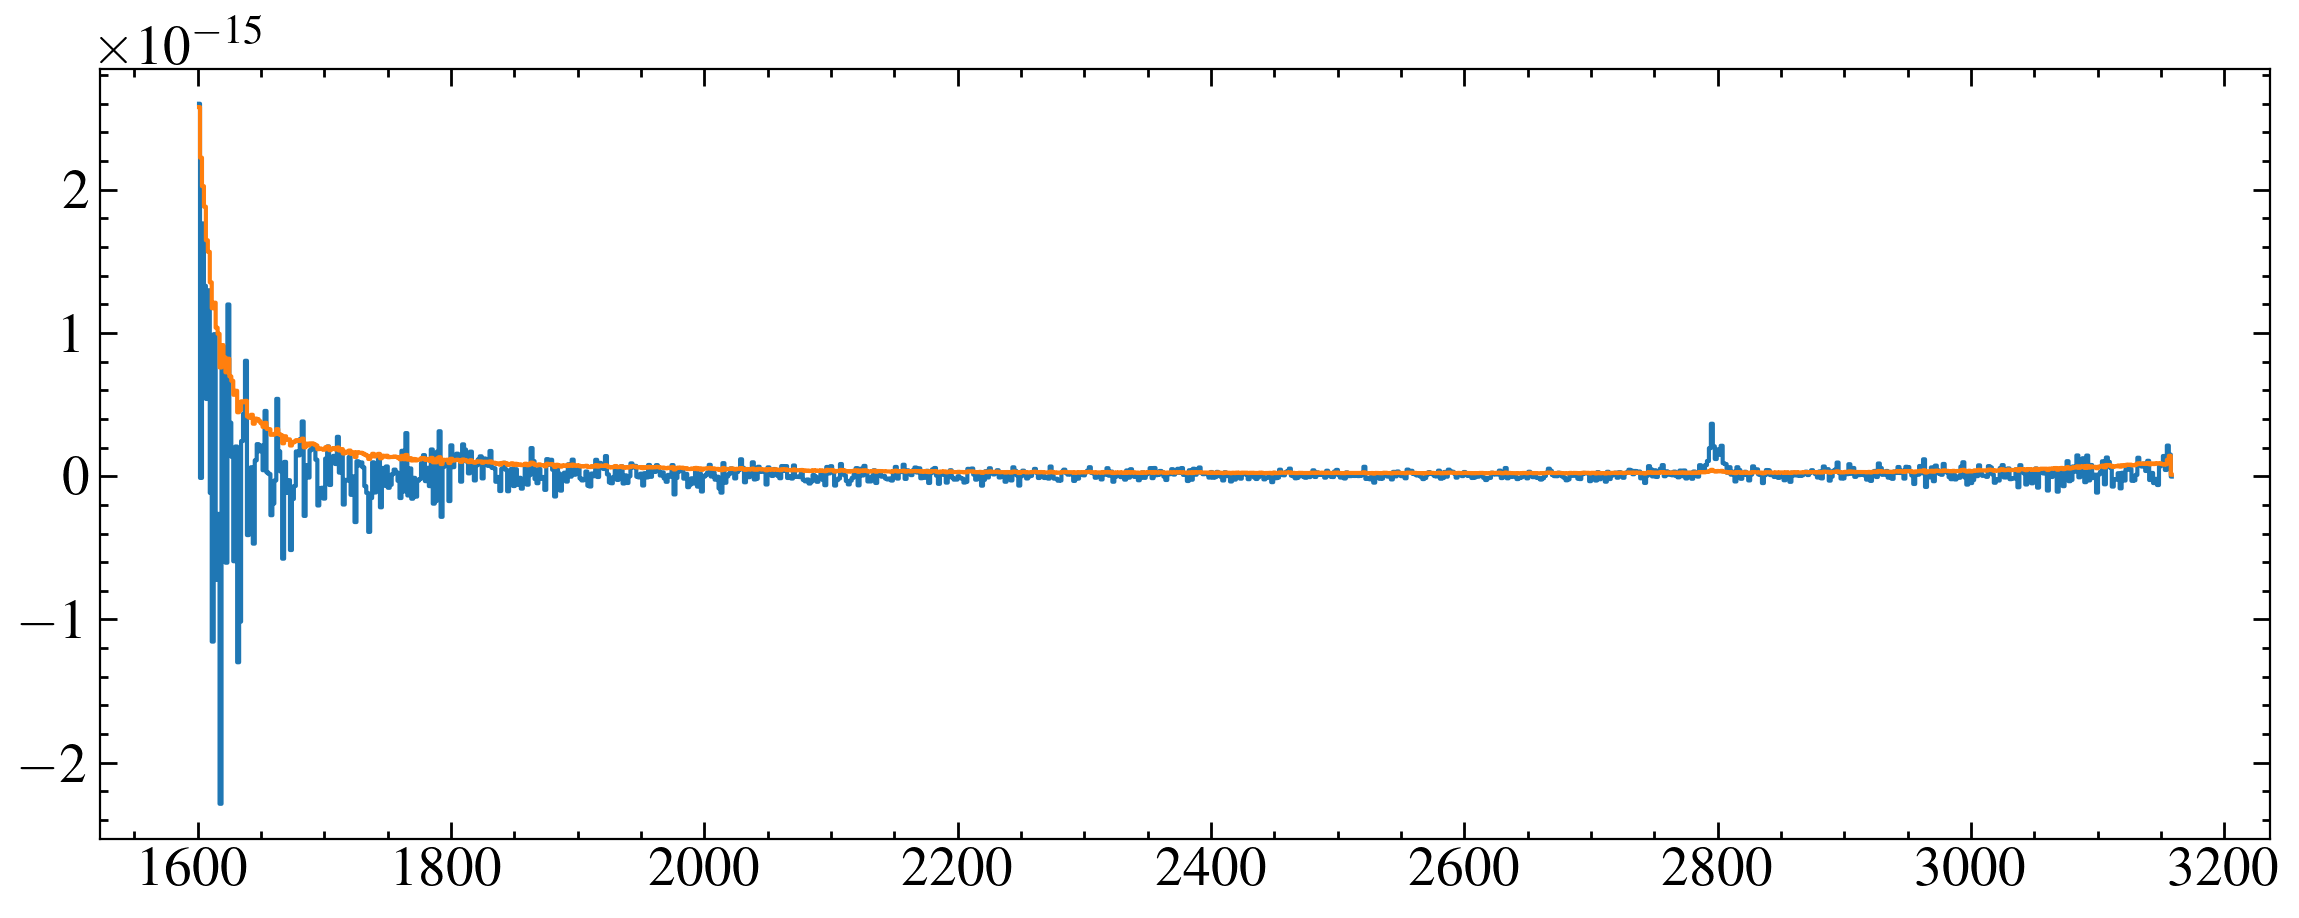

/media/david/2tb_ext_hd/hddata/meats/hst/lhs_1140/stis/odmw03010_x1d.fits
G140M
557.29224


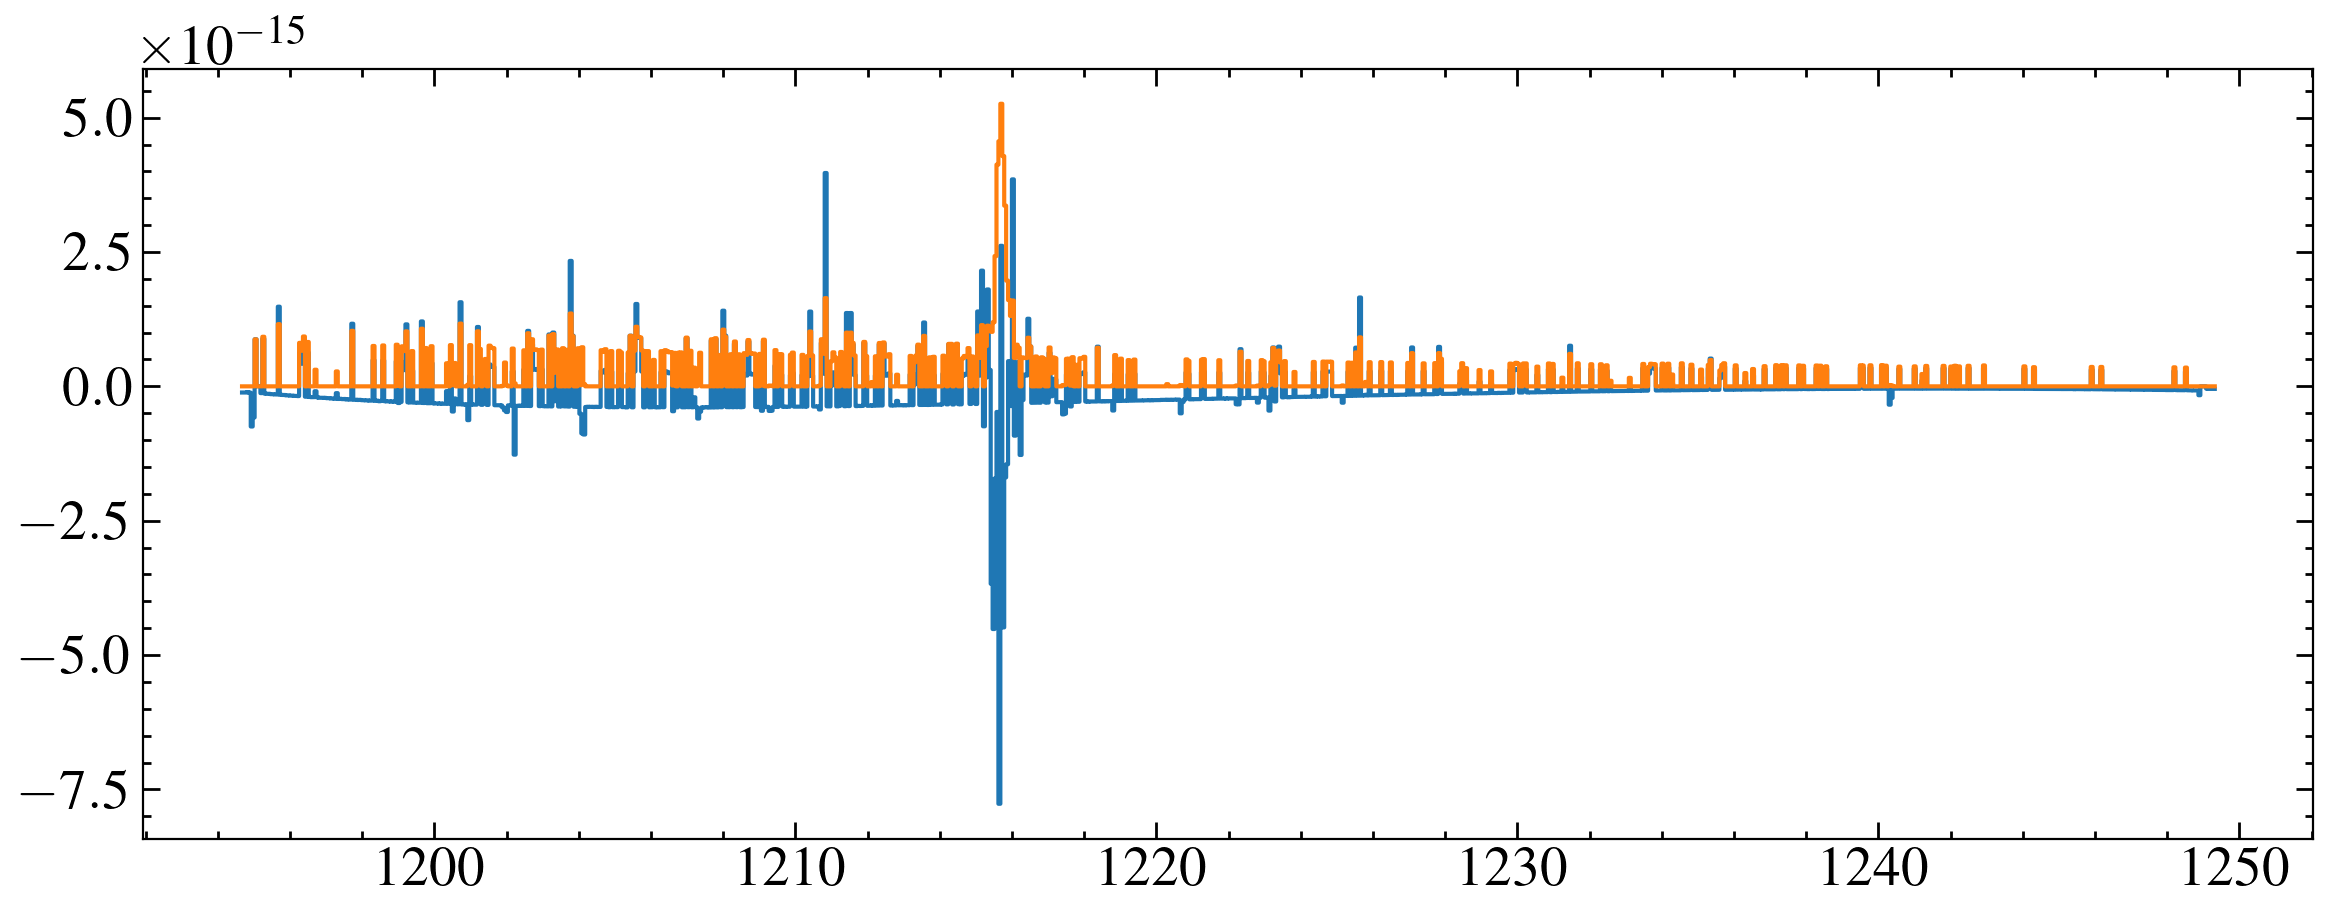

/media/david/2tb_ext_hd/hddata/meats/hst/lhs_1140/stis/odmw03020_x1d.fits
G230L
1026.4008


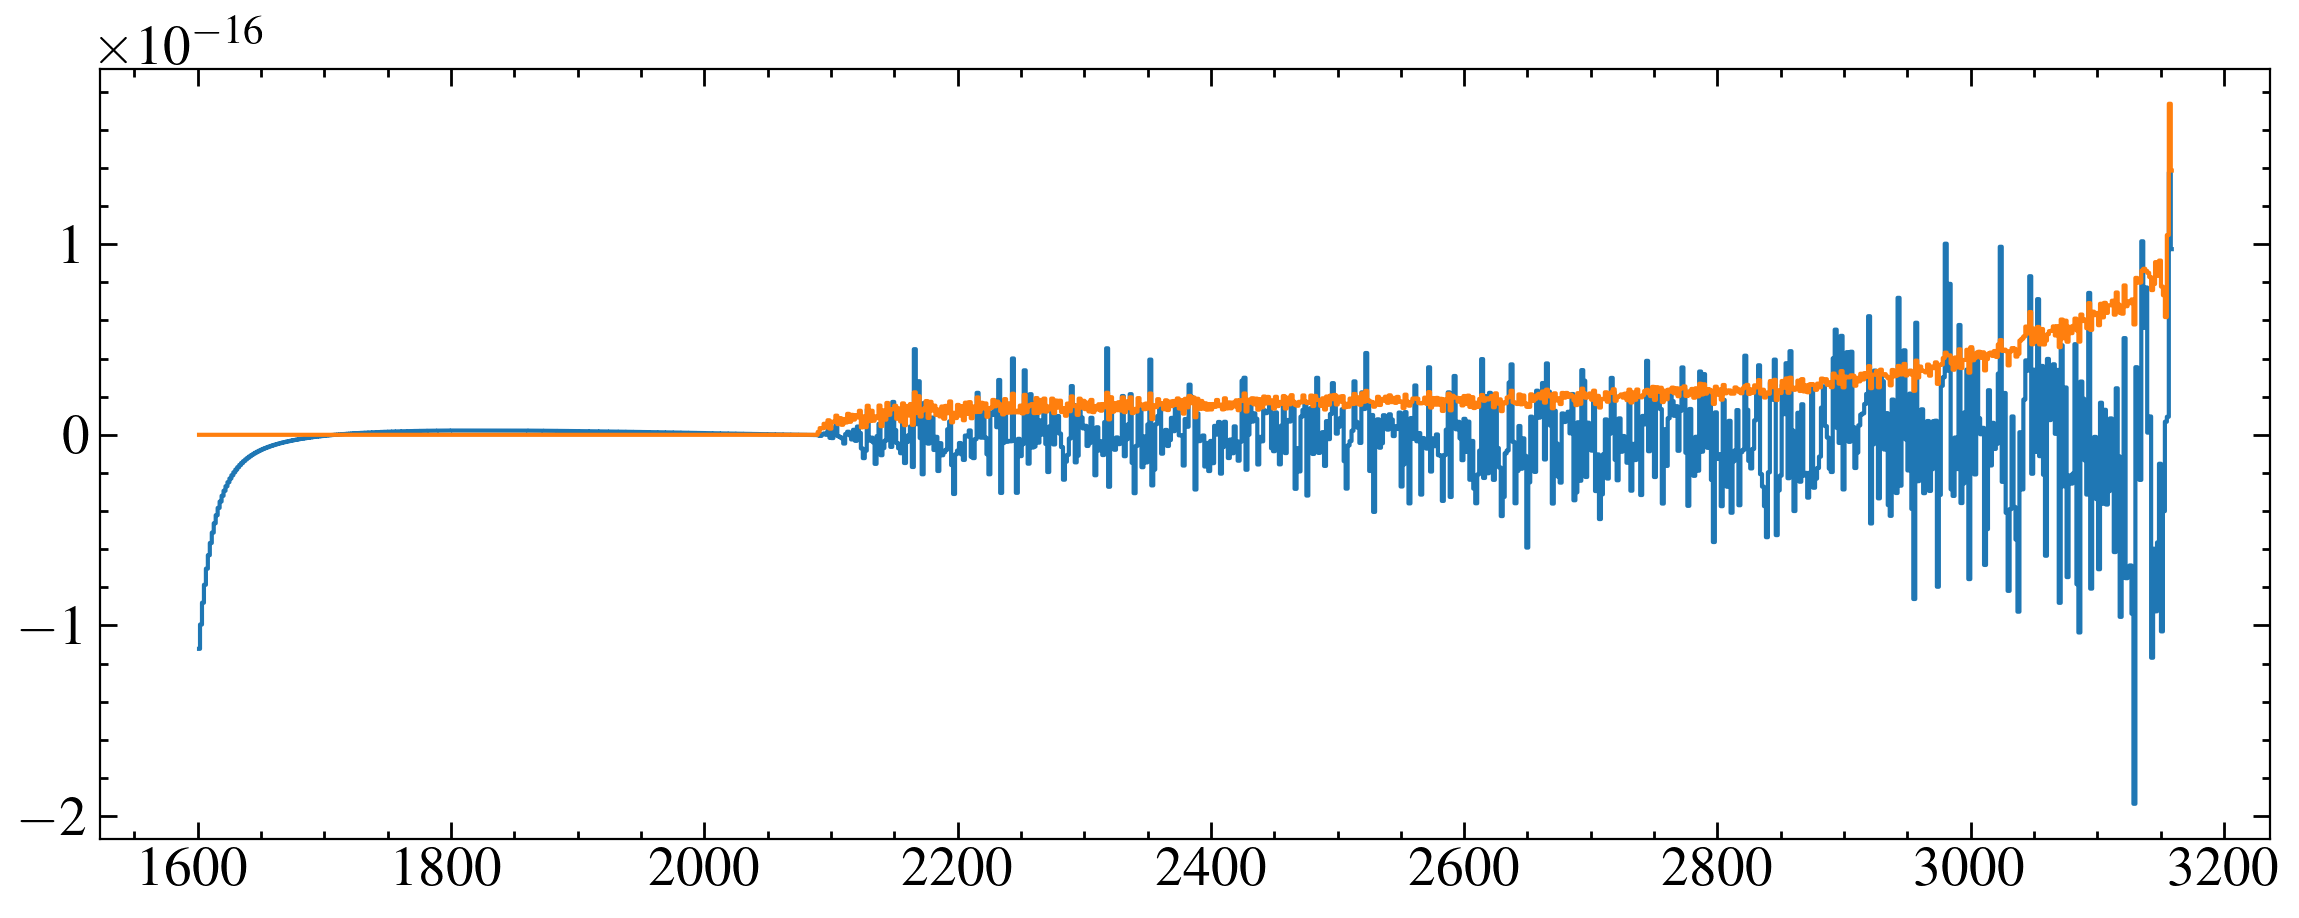

/media/david/2tb_ext_hd/hddata/meats/hst/lhs_1140/stis/odmw04020_x1d.fits
G230L
533.31854


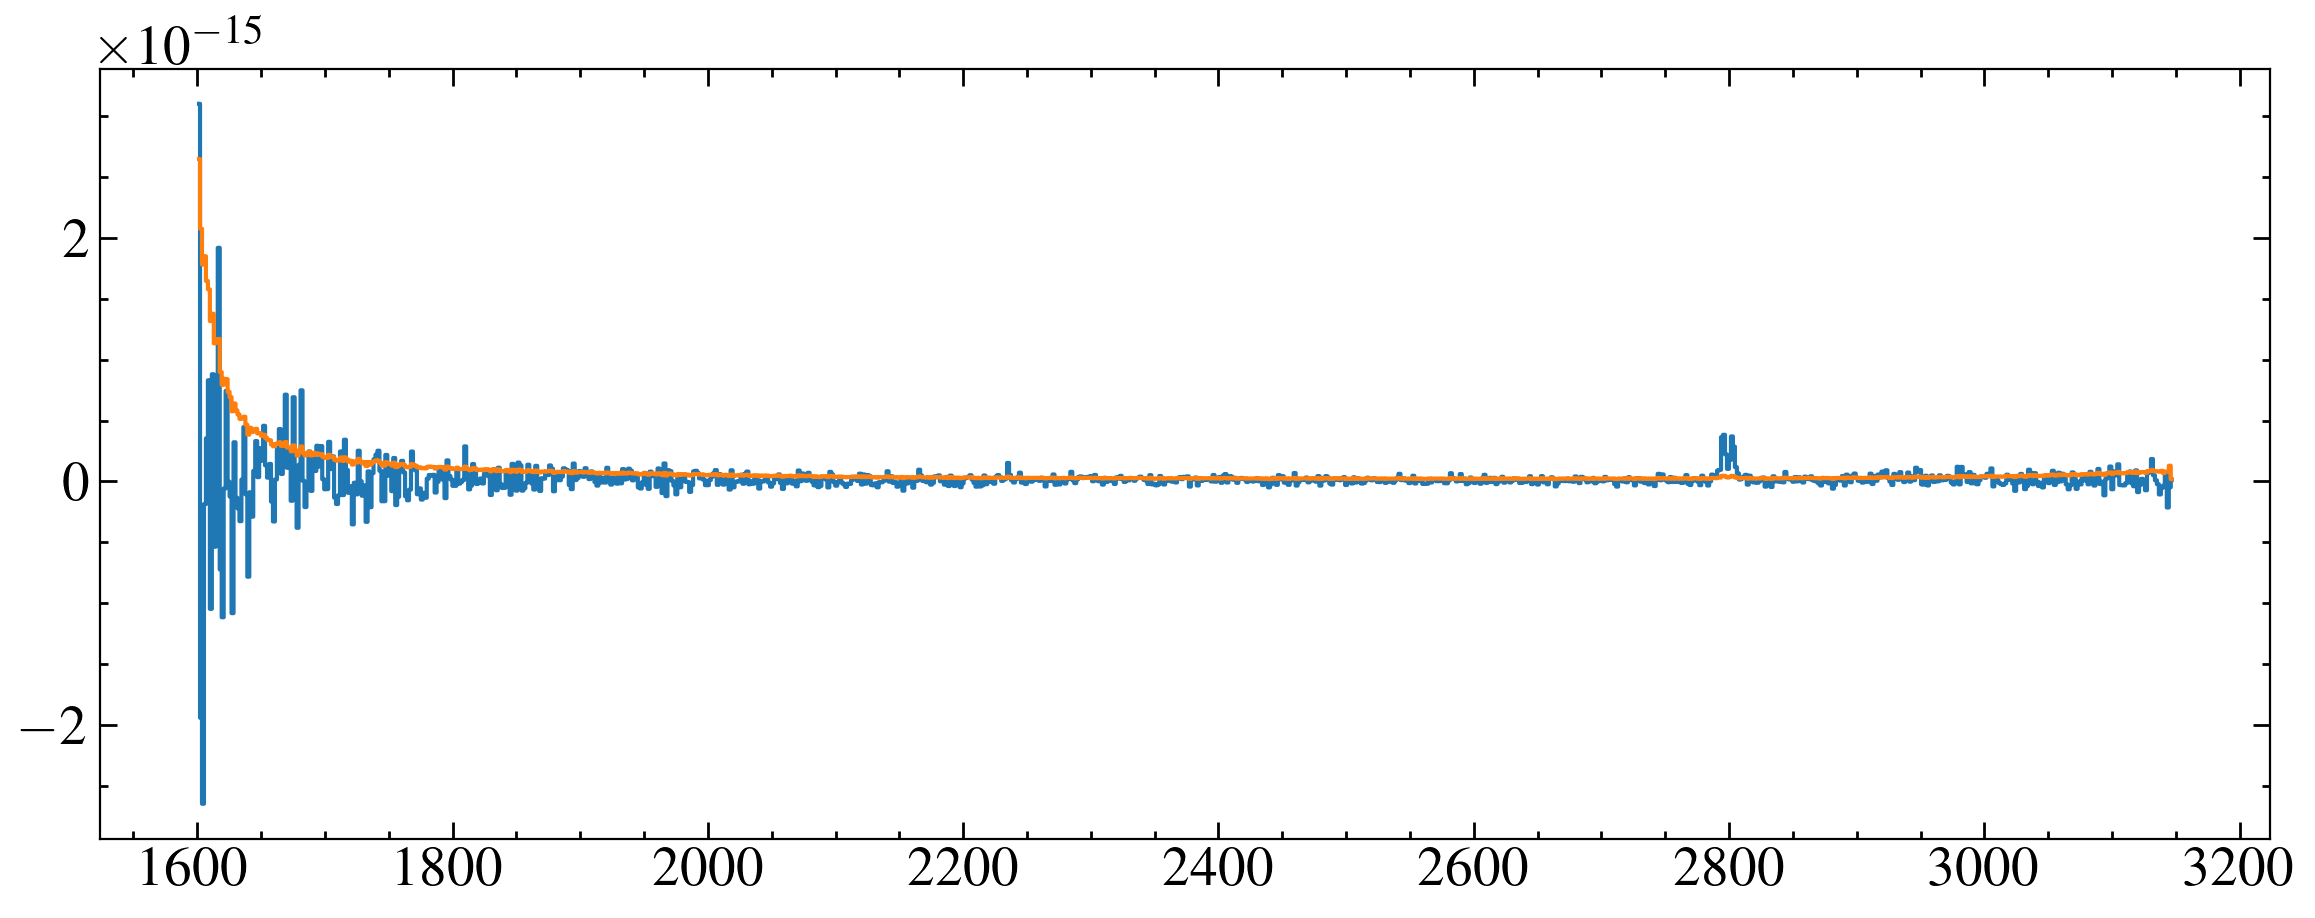

In [23]:
for x in x1ds:
    print(x)
    grating = fits.getheader(x, 0)['OPT_ELEM'] 
    print(grating)
    data = fits.getdata(x, 1)[0]
    print(data['A2Center'])
    w, f, e= data['WAVELENGTH'], data['FLUX'], data['ERROR']
    if grating == 'G230L':
        mask = w > 1600
        w, f, e = w[mask], f[mask], e[mask]
    plt.step(w, f, where='mid')
    plt.step(w, e, where='mid')
    plt.show()
    

In [24]:
for x in x1ds:
    # print(x)
    grating = fits.getheader(x, 0)['OPT_ELEM'] 
    if grating =='G140M':
        print(fits.getheader(x, 0)['ROOTNAME'])

ode406010
odmw01010
odmw04010
odmw02010
odmw03010


In [25]:
import stistools
os.environ['oref'] = path

def build_trace_grid(SPTRCTAB, grating, cenwave):
    """
    Extends a grid of trace displacements to cover all y positions
    """
    data = fits.getdata(SPTRCTAB, 1)
    tracedata = data[(data['OPT_ELEM']==grating) & (data['CENWAVE'] == cenwave)]
    all_y = np.arange(len(tracedata[0]['A2DISPL']))
    grid = interp1d(tracedata['A2CENTER'], tracedata['A2DISPL'], axis=0, fill_value='extrapolate')(all_y)
    tracegrid = [a+b for a, b in zip(grid, all_y)] 
    return tracegrid
    
def get_a2center(x, y, tracegrid):
    """
    get the trace a2center at a1center
    """
    xcol = np.array(tracegrid)[:,int(x)]
    xind = (np.abs(xcol - y)).argmin()
    a2center = xind + 1 #calstis is 1-indexed 
    return a2center

407


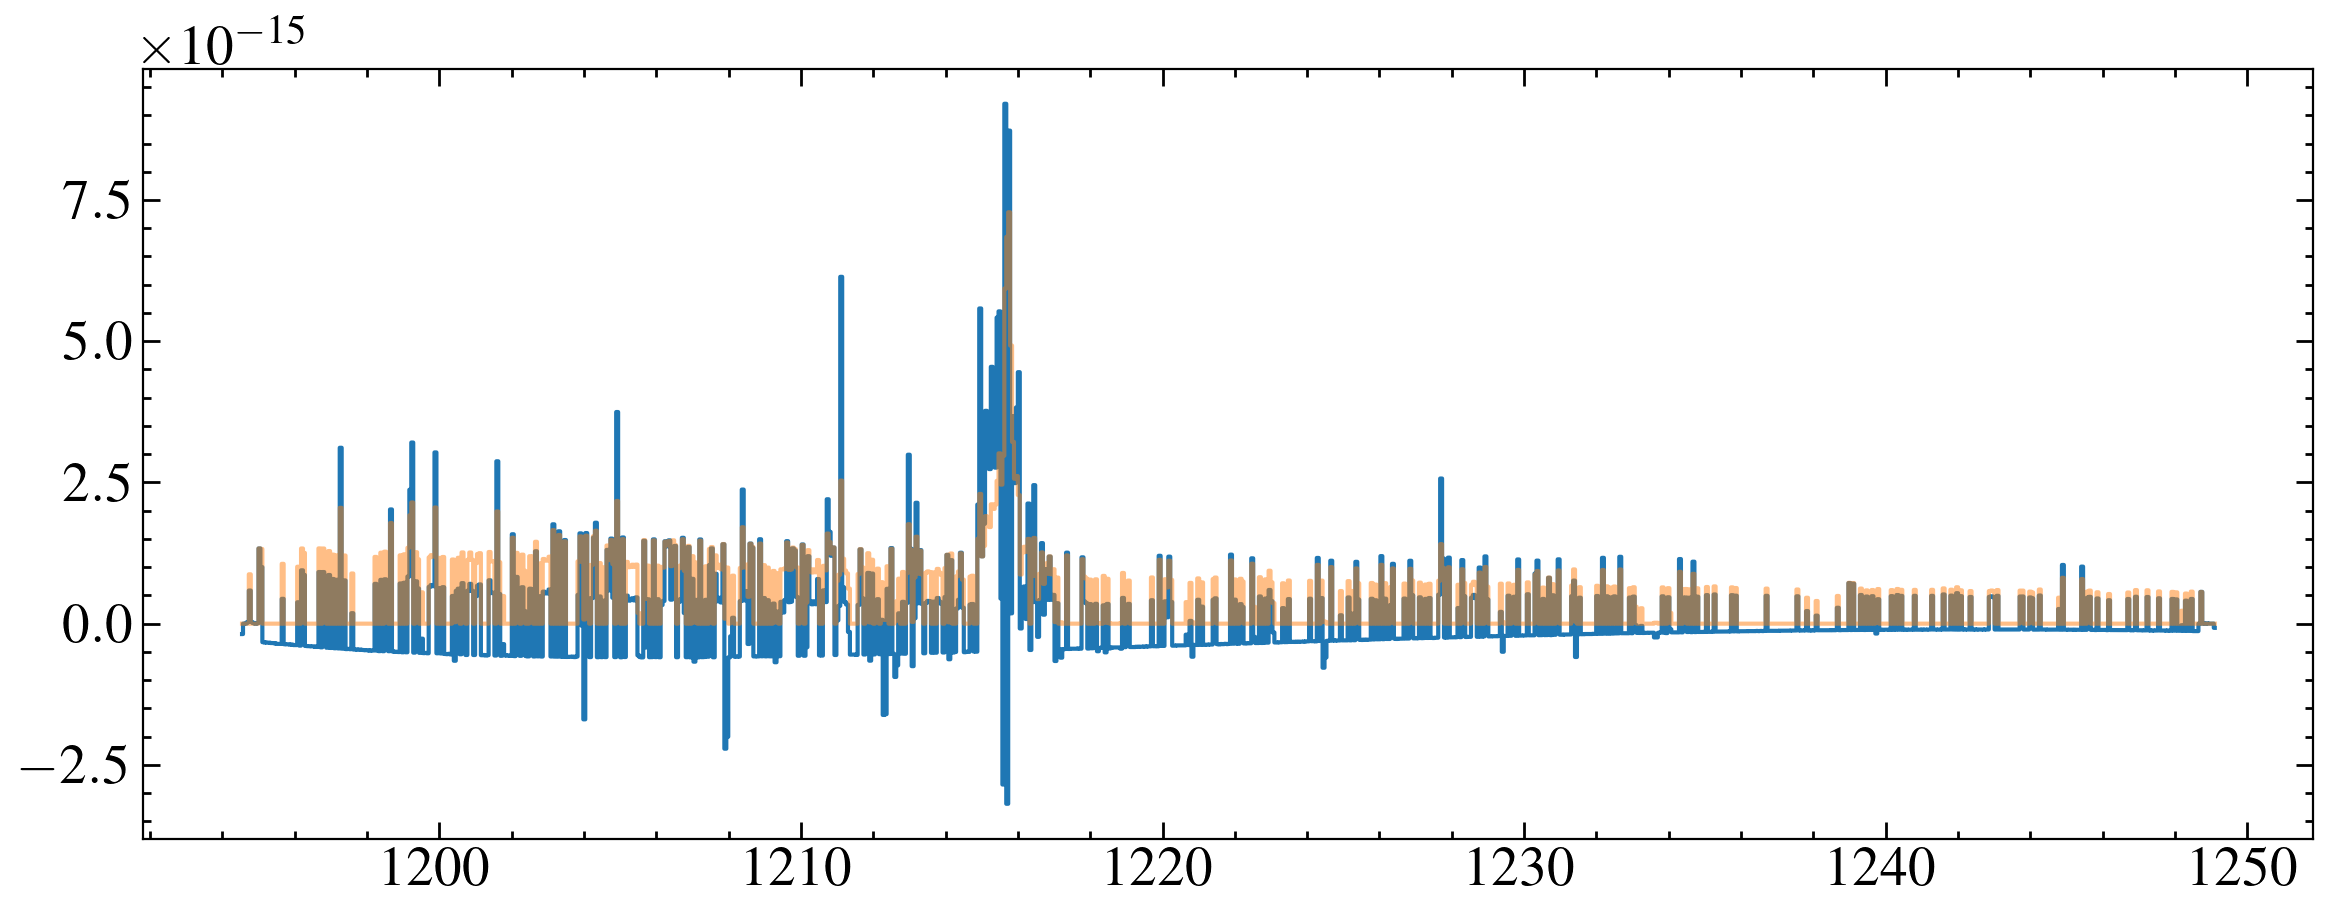

179


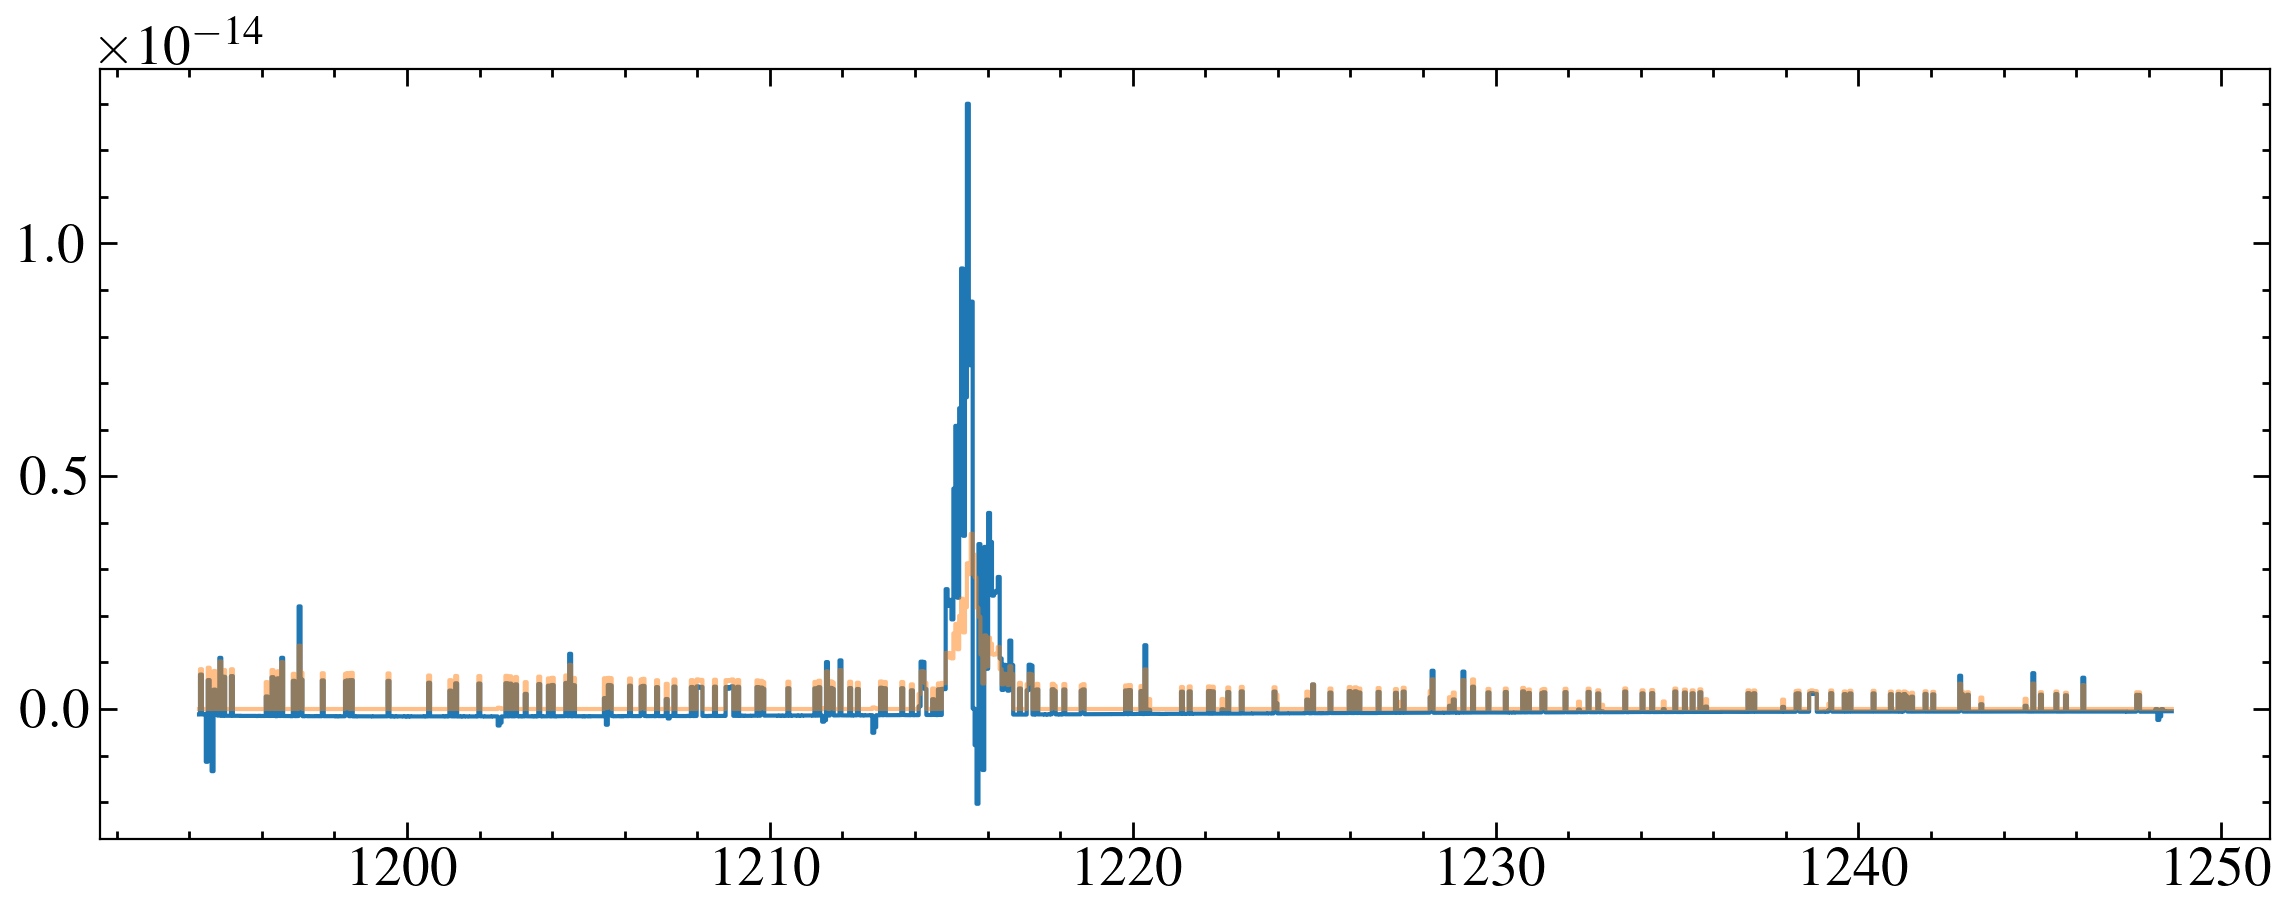

173


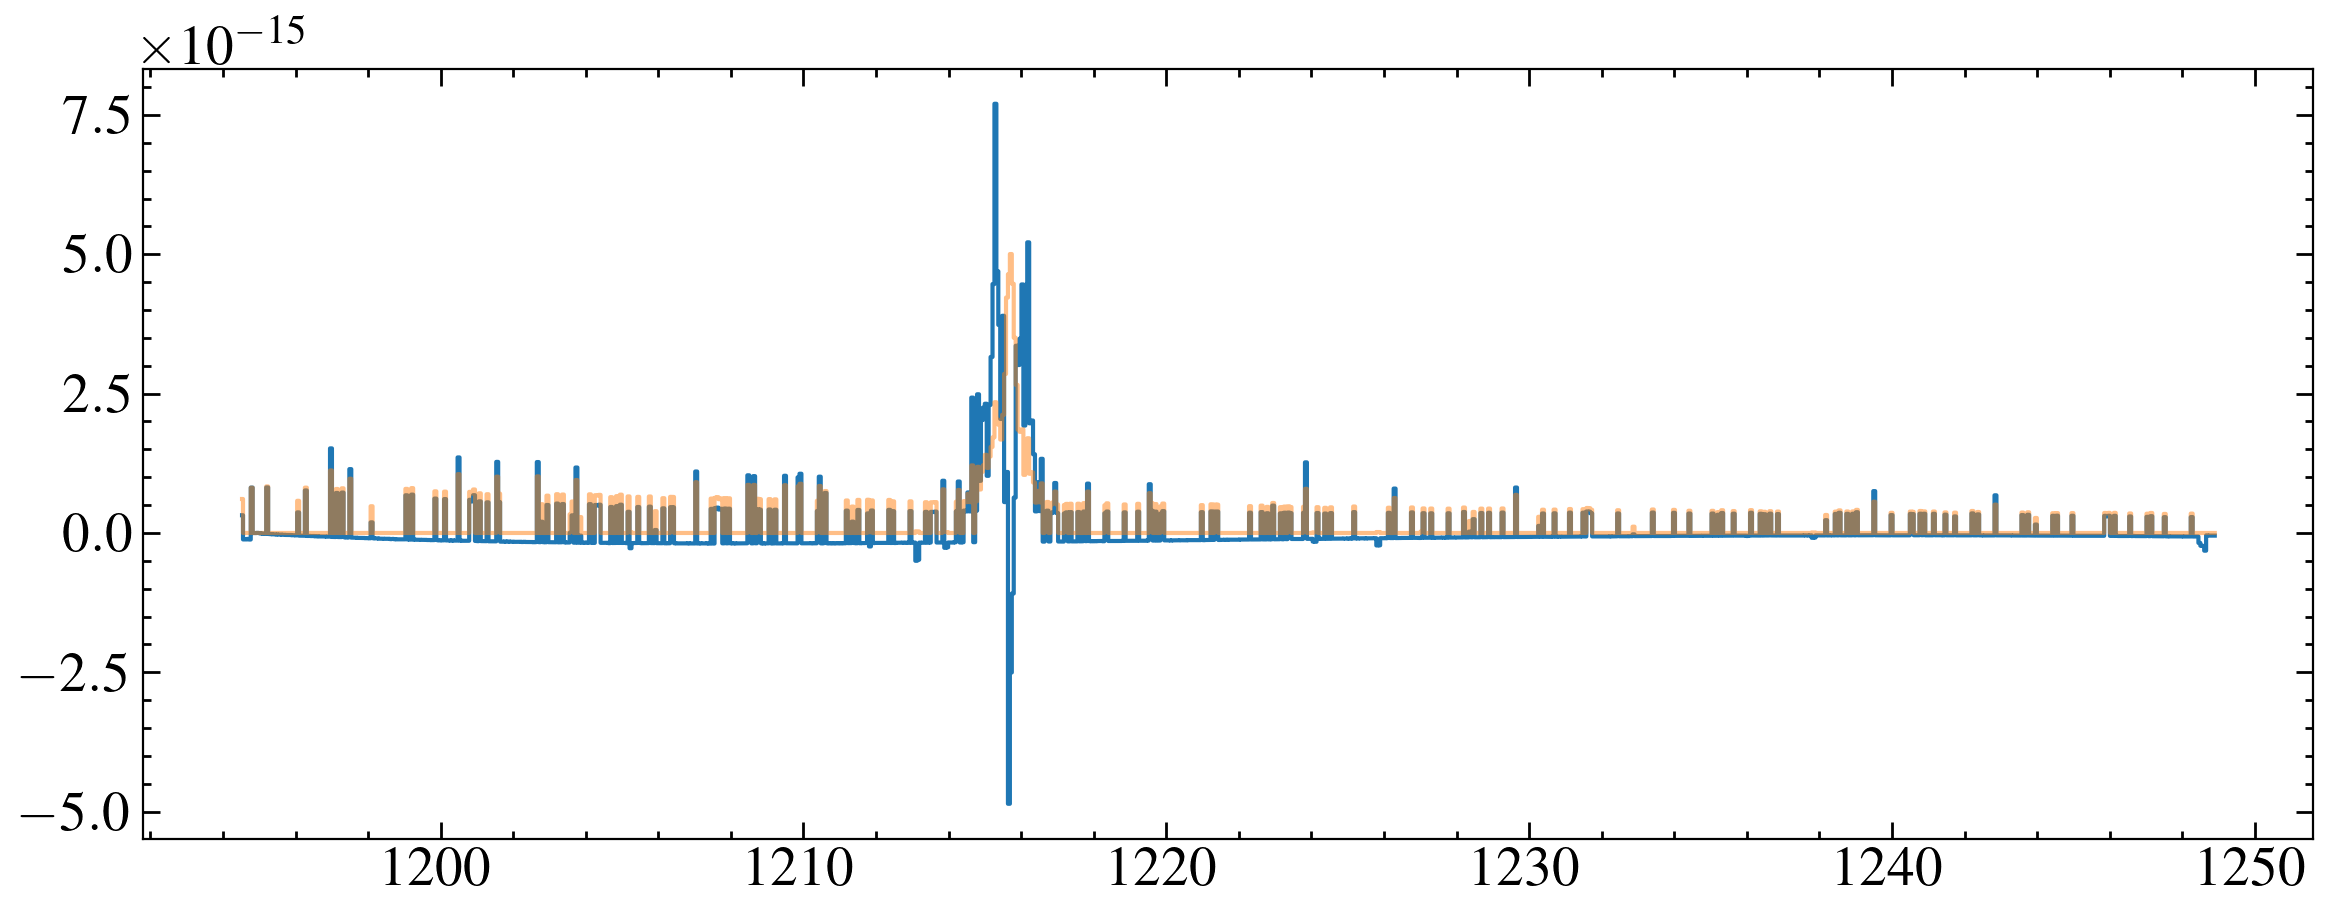

515


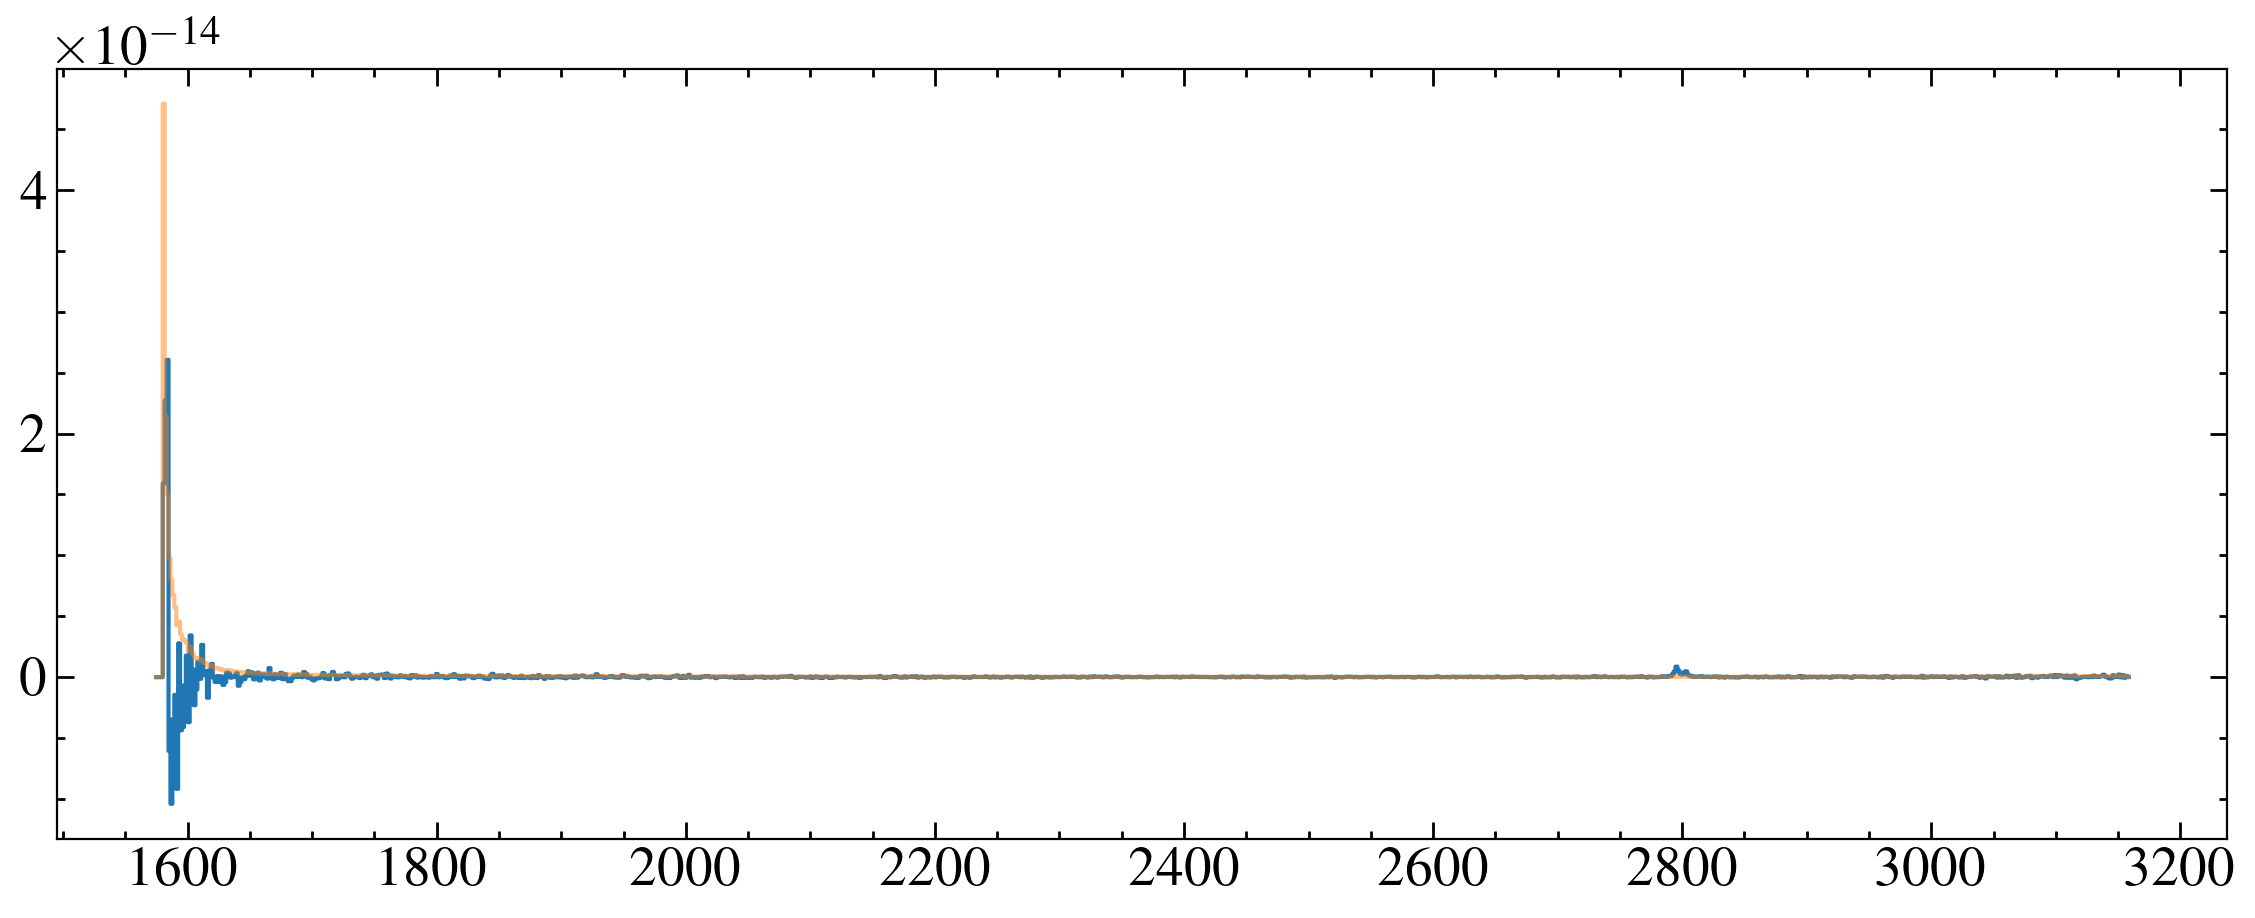

In [26]:
ys = [404,177, 171, 509]
xs = [390,395, 391, 802]

roots = ['ode406010', 'odmw01010', 'odmw03010', 'odmw03020']


for i, root in  enumerate(roots):
    flt = '{}/{}_flt.fits'.format(path, root)
    SPTRCTAB = fits.getheader(flt,0)['SPTRCTAB']
    grating = fits.getheader(flt,0)['OPT_ELEM']
    cenwave = fits.getheader(flt,0)['CENWAVE']
    tracegrid = build_trace_grid(path+SPTRCTAB[5:], grating, cenwave)
    rootname = fits.getheader(flt)['ROOTNAME'] 
    outname = 'reextractions/lhs_1140/{}_new_x1d.fits'.format(rootname)
    if os.path.exists(outname):
        os.remove(outname)
    a2center = get_a2center(xs[i], ys[i], tracegrid)
    print(a2center)
    stistools.x1d.x1d(flt, output = outname, trailer='reextractions/lhs_1140/{}_new.trl'.format(rootname), a2center=a2center, maxsrch=0)

    fig, ax = plt.subplots()
    data = fits.getdata(outname, 1)[0]
    ax.step(data['WAVELENGTH'], data['FLUX'], where='mid')
    ax.step(data['WAVELENGTH'], data['ERROR'], where='mid', alpha=0.5)
    plt.show()
    


/home/david/anaconda3/envs/stenv/lib/python3.11/site-packages/astropy/stats/funcs.py:698: RuntimeWarning: invalid value encountered in sqrt
  [n + 0.5 - np.sqrt(n + 0.25), n + 0.5 + np.sqrt(n + 0.25)]
/home/david/work/meats/SEDs/prepare_stis.py:36: RuntimeWarning: divide by zero encountered in divide
  weights = 1 / (e_array**2)
/home/david/anaconda3/envs/stenv/lib/python3.11/site-packages/numpy/lib/function_base.py:553: RuntimeWarning: invalid value encountered in multiply
  avg = avg_as_array = np.multiply(a, wgt,


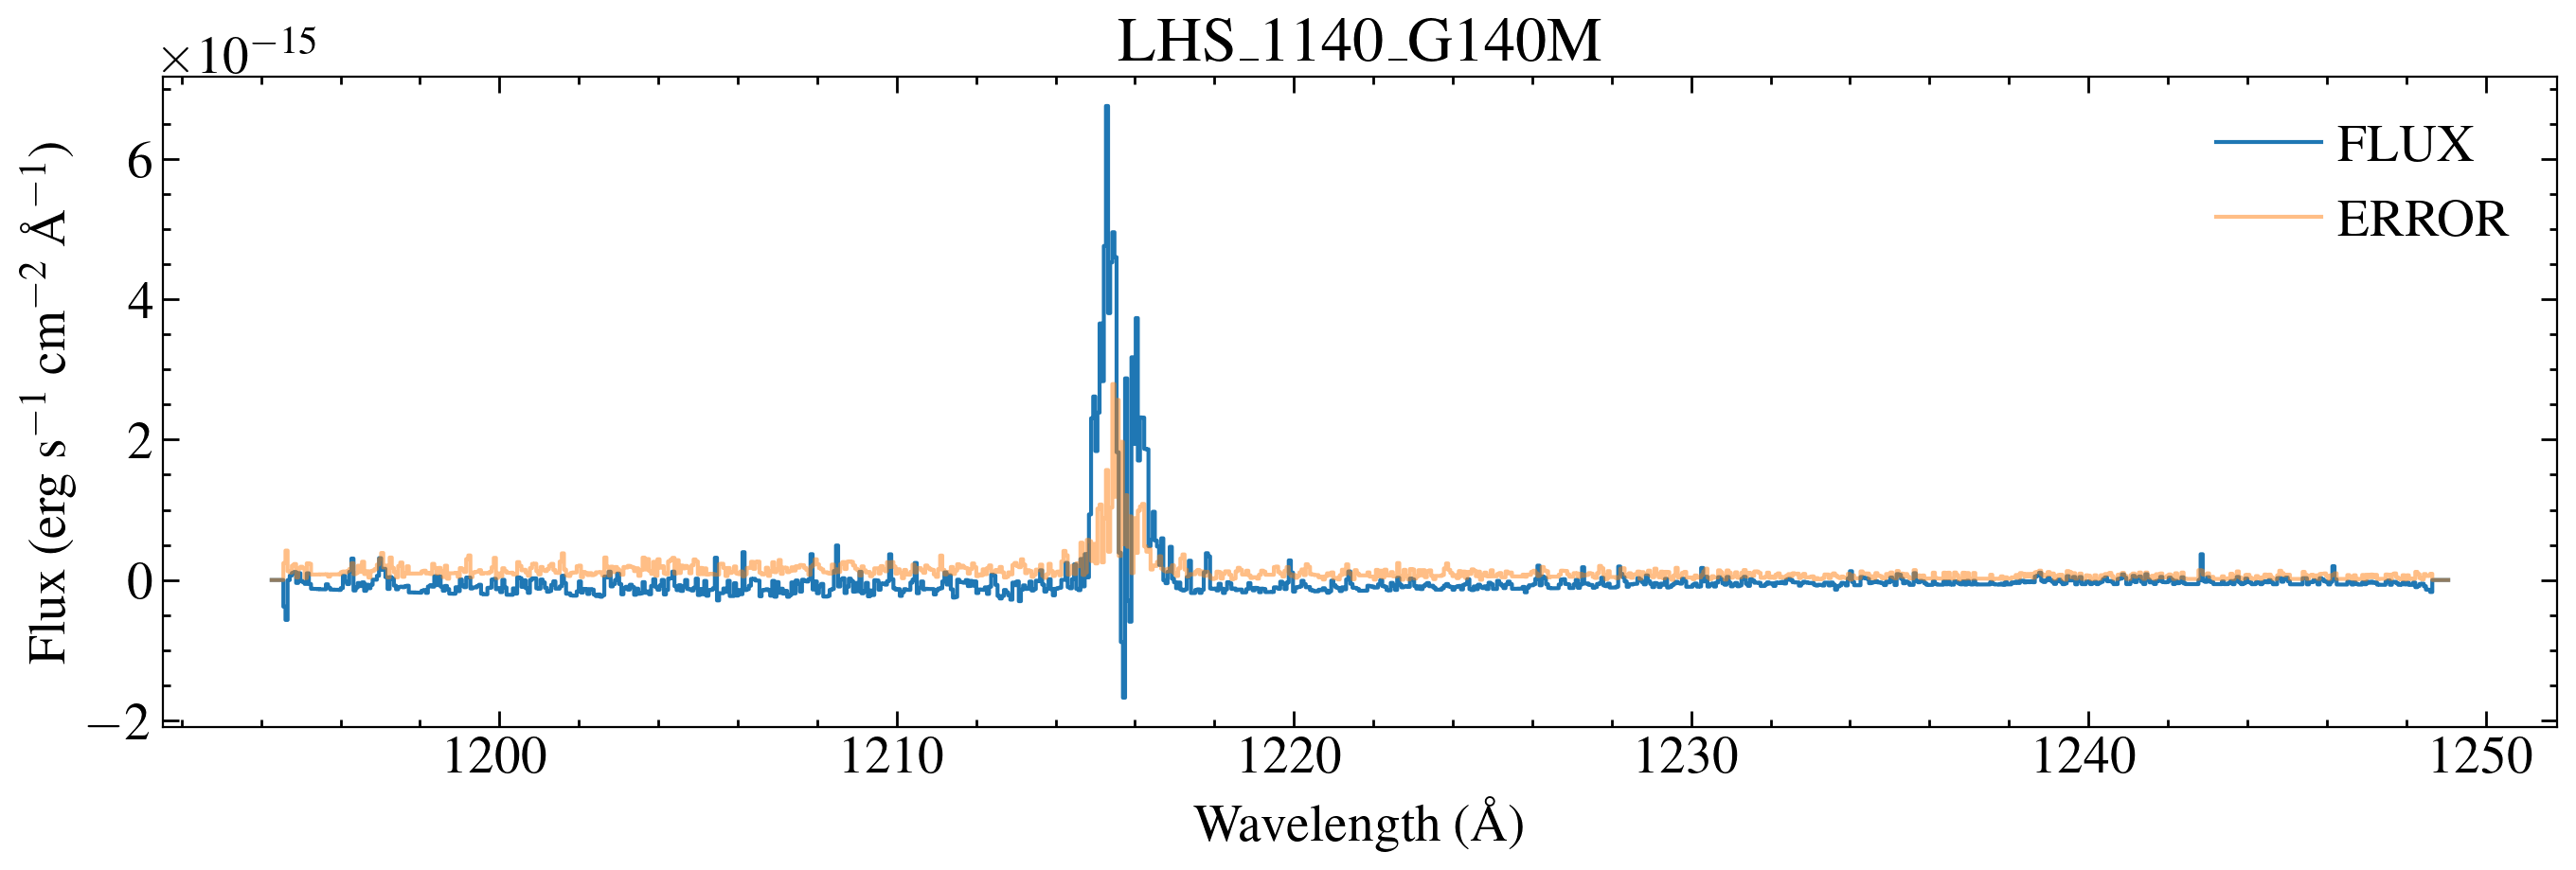

Spectrum saved as hlsp_muscles_hst_stis_lhs_1140_g140m_v1_component-spec.fits


/home/david/work/meats/SEDs/prepare_stis.py:36: RuntimeWarning: divide by zero encountered in divide
  weights = 1 / (e_array**2)
/home/david/anaconda3/envs/stenv/lib/python3.11/site-packages/numpy/lib/function_base.py:553: RuntimeWarning: invalid value encountered in multiply
  avg = avg_as_array = np.multiply(a, wgt,


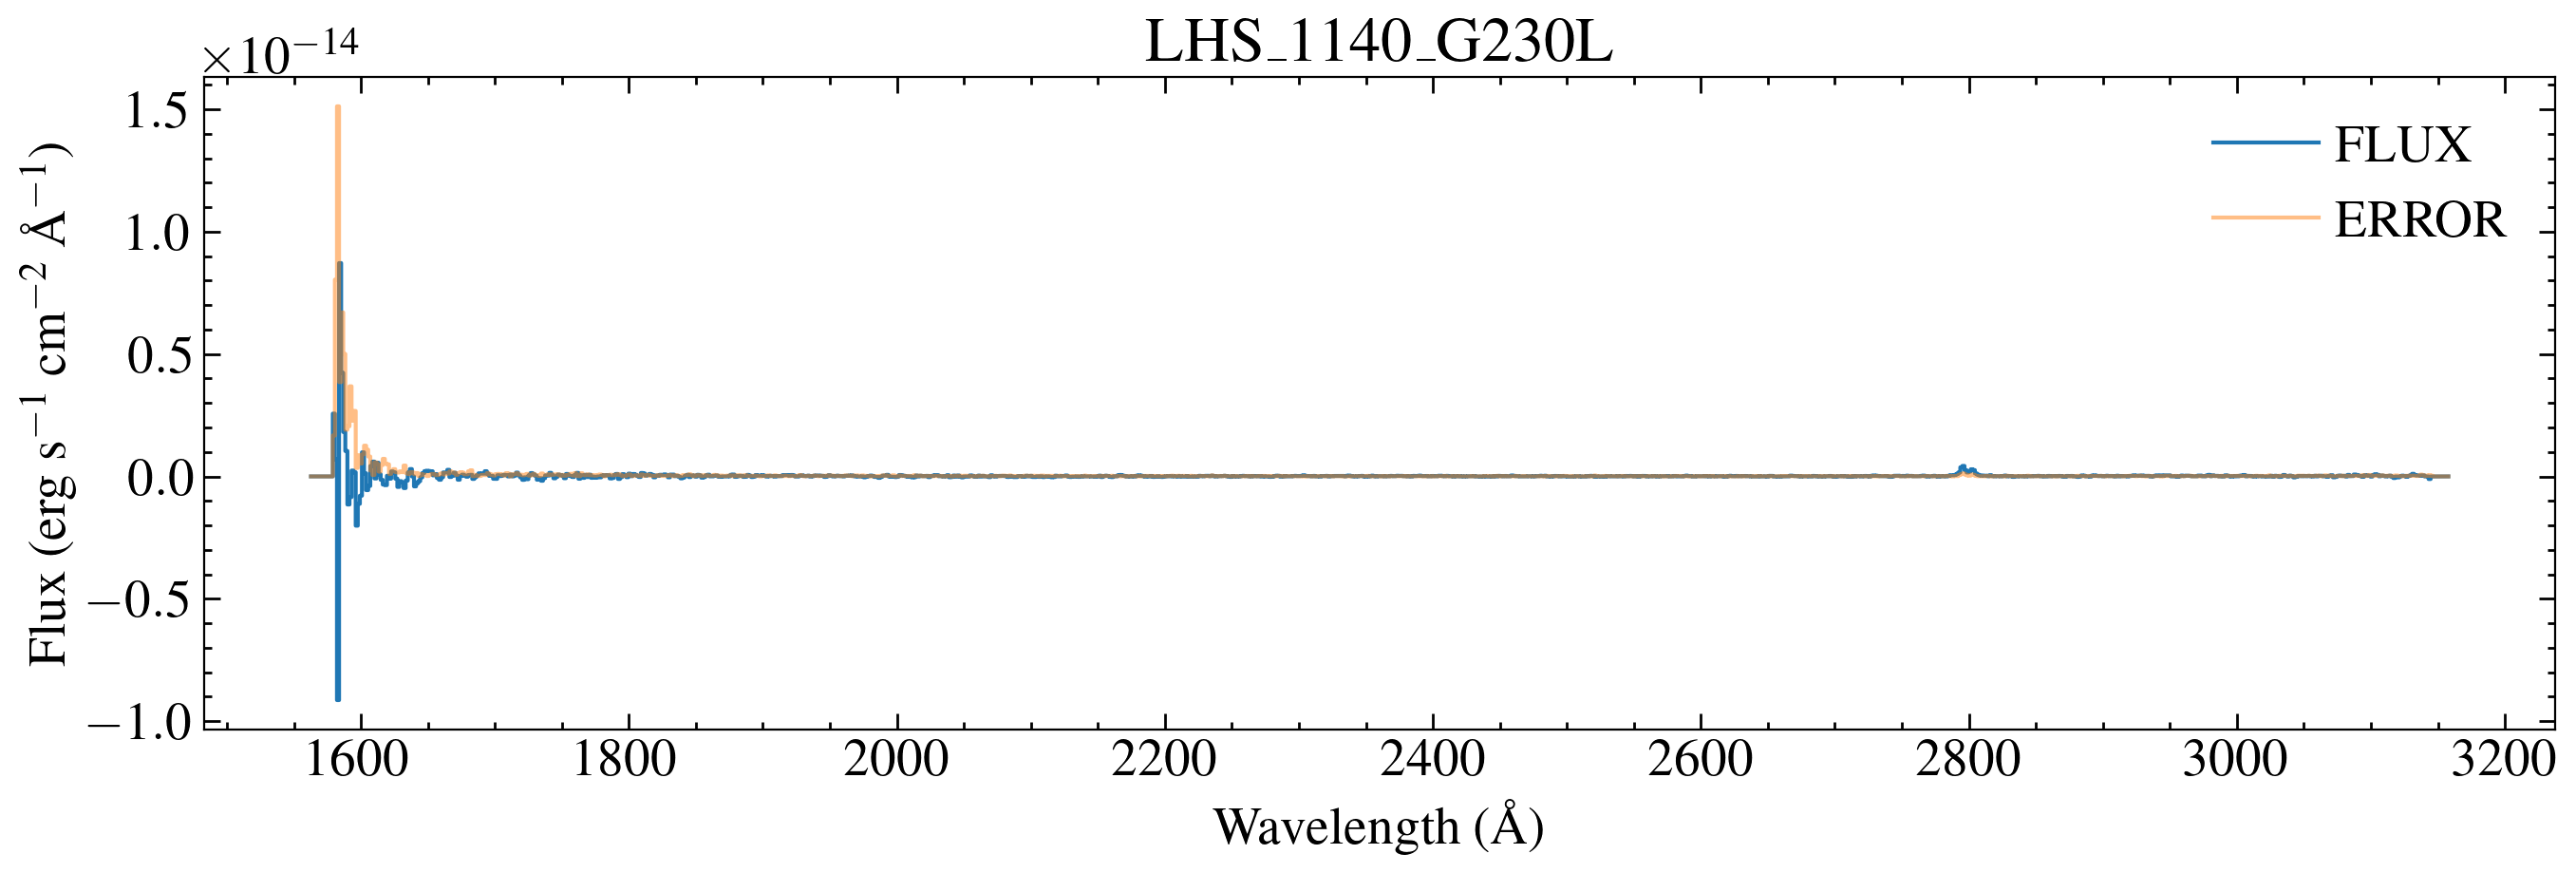

Spectrum saved as hlsp_muscles_hst_stis_lhs_1140_g230l_v1_component-spec.fits


In [27]:
import prepare_stis
x1dpath = '/media/david/2tb_ext_hd/hddata/meats/hst/lhs_1140/stis/use_spectra/'
savepath = 'draft_hlsp/lhs_1140//'
hlsp = 'meats_hlsp_info.csv'
version = 1
prepare_stis.make_stis_spectrum(x1dpath, version, hlsp, savepath = savepath, plot=True, save_fits=True, normfac=1.0, star = 'LHS_1140')

In [28]:
hlsp_stis = glob.glob('draft_hlsp/lhs_1140/*stis*.fits')
hlsp_stis

['draft_hlsp/lhs_1140/hlsp_muscles_hst_stis_lhs_1140_g230l_v1_component-spec.fits',
 'draft_hlsp/lhs_1140/hlsp_muscles_hst_stis_lhs_1140_g140m_v1_component-spec.fits']

draft_hlsp/lhs_1140/hlsp_muscles_hst_stis_lhs_1140_g230l_v1_component-spec.fits
G230L


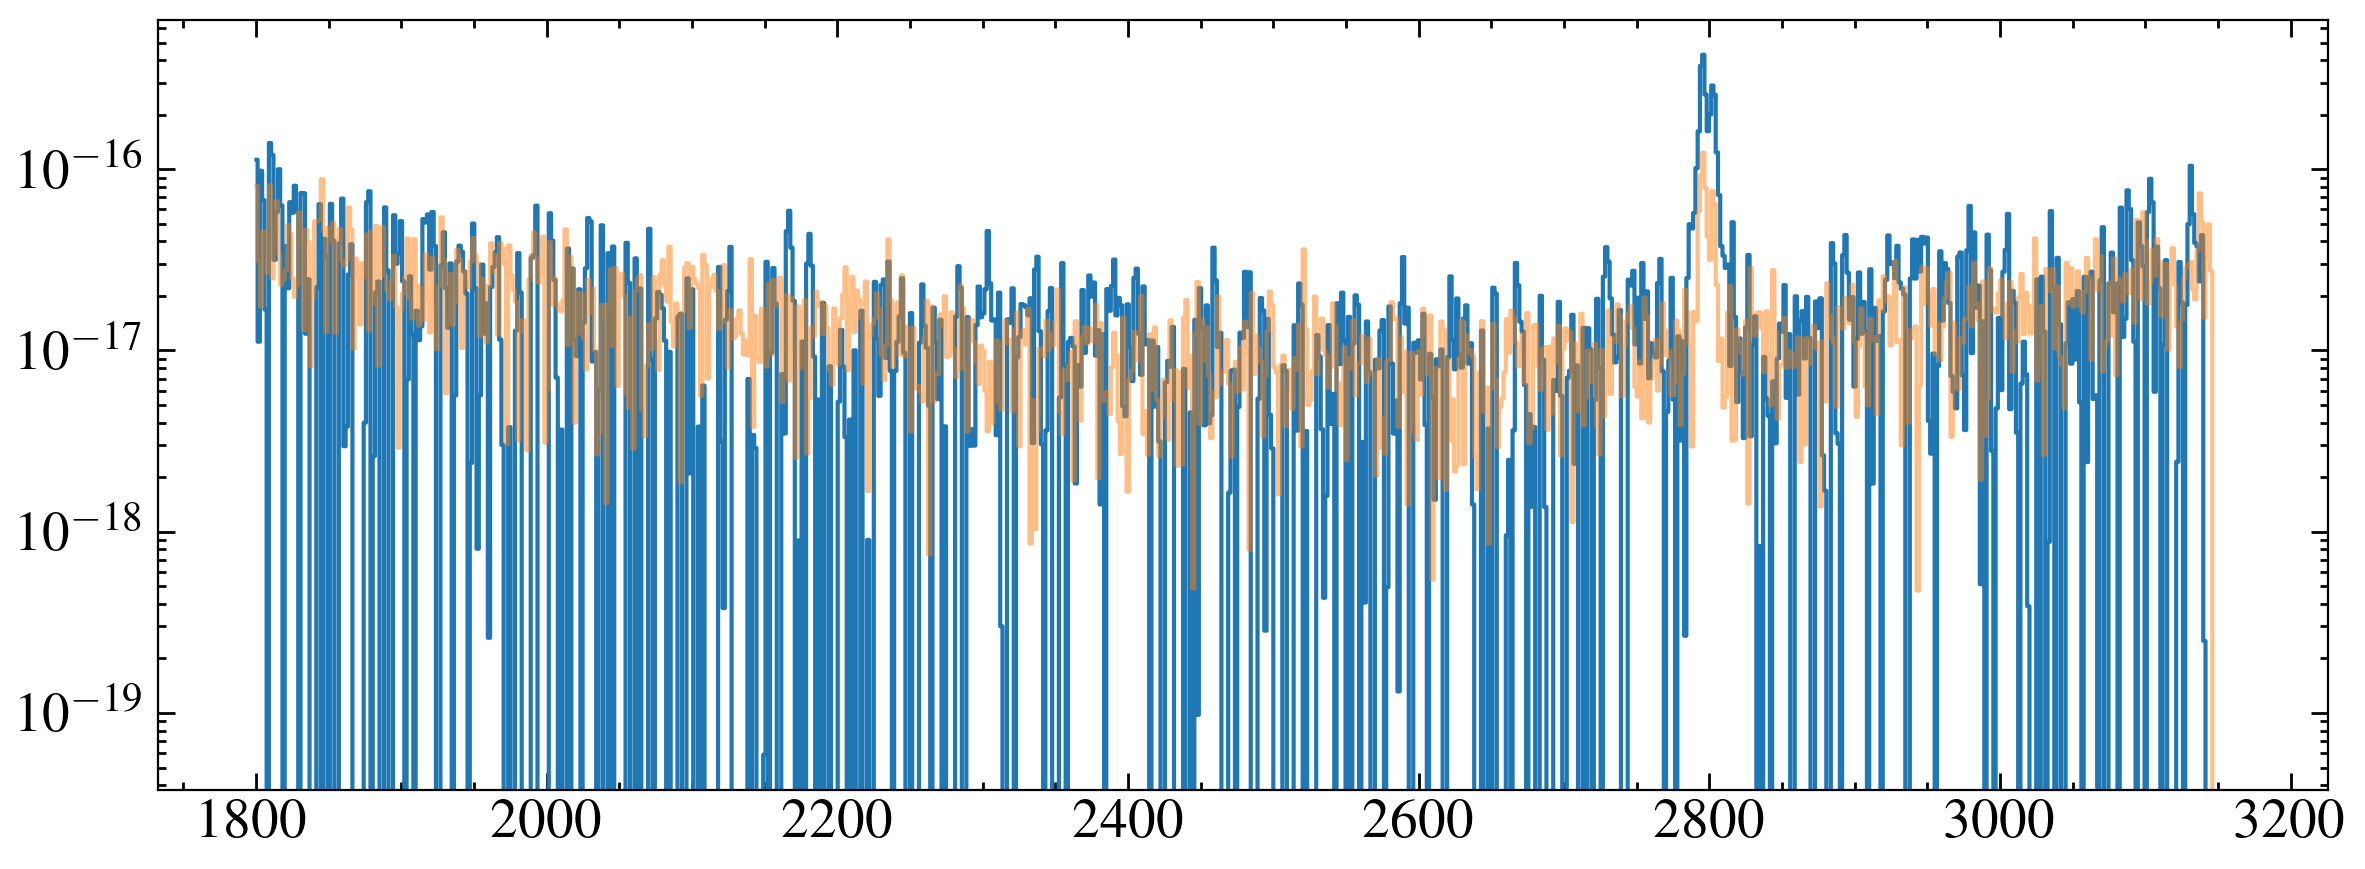

draft_hlsp/lhs_1140/hlsp_muscles_hst_stis_lhs_1140_g140m_v1_component-spec.fits
G140M


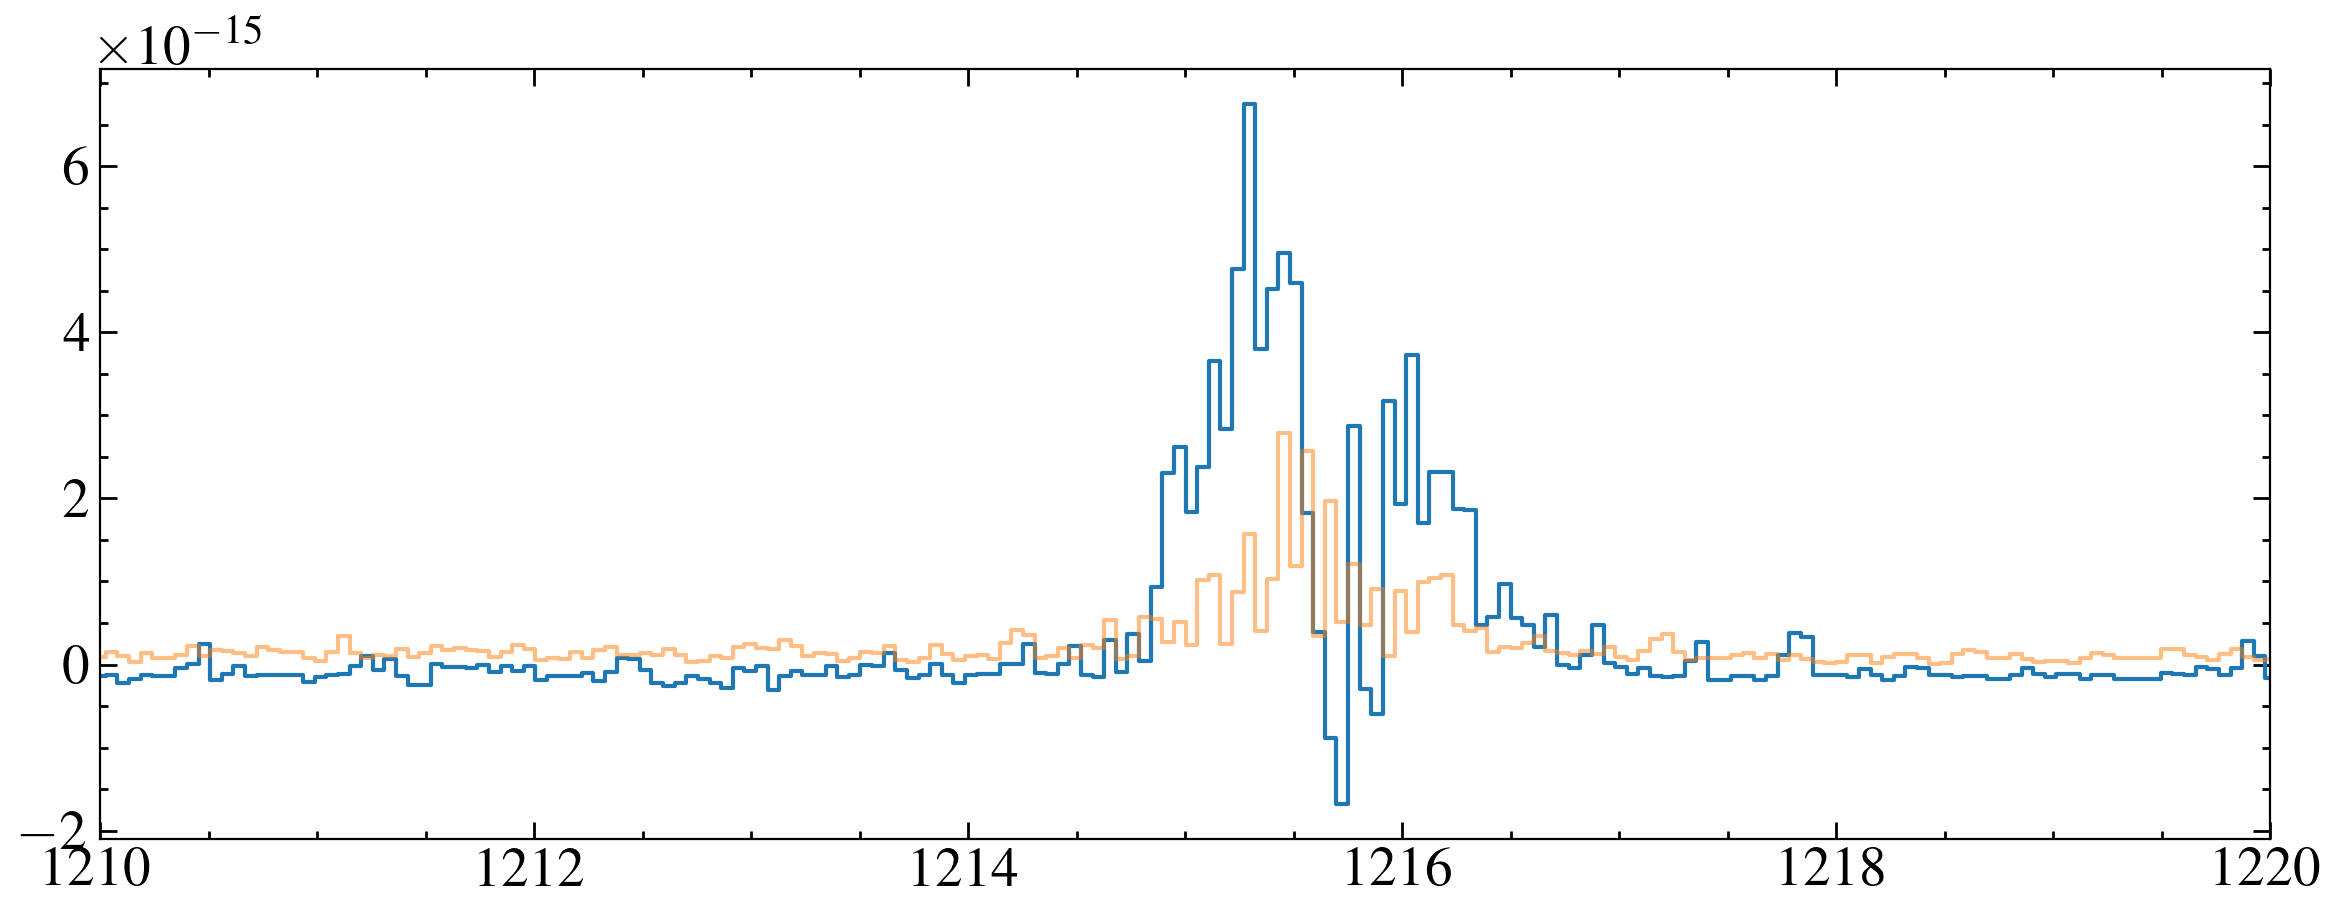

In [29]:
for x in hlsp_stis:
    print(x)
    fig, ax = plt.subplots()
    grating = fits.getheader(x, 0)['GRATING'] 
    print(grating)
    data = fits.getdata(x, 1)
    w, f, e= data['WAVELENGTH'], data['FLUX'], data['ERROR']
    if grating == 'G230L':
        mask = w > 1800
        w, f, e = w[mask], f[mask], e[mask]
        ax.set_yscale('log')
    if grating == 'G140M':
        ax.set_xlim(1210, 1220)
    plt.step(w, f, where='mid')
    plt.step(w, e, where='mid', alpha=0.5)
    plt.show()
    

/media/david/2tb_ext_hd/hddata/meats/hst/lhs_1140/stis/use_spectra/ode406010_new_x1d.fits
G140M
/media/david/2tb_ext_hd/hddata/meats/hst/lhs_1140/stis/use_spectra/odmw01010_new_x1d.fits
G140M
/media/david/2tb_ext_hd/hddata/meats/hst/lhs_1140/stis/use_spectra/odmw02020_x1d.fits
G230L
/media/david/2tb_ext_hd/hddata/meats/hst/lhs_1140/stis/use_spectra/odmw03010_new_x1d.fits
G140M
/media/david/2tb_ext_hd/hddata/meats/hst/lhs_1140/stis/use_spectra/odmw03020_new_x1d.fits
G230L
/media/david/2tb_ext_hd/hddata/meats/hst/lhs_1140/stis/use_spectra/odmw04020_x1d.fits
G230L


(1210.0, 1220.0)

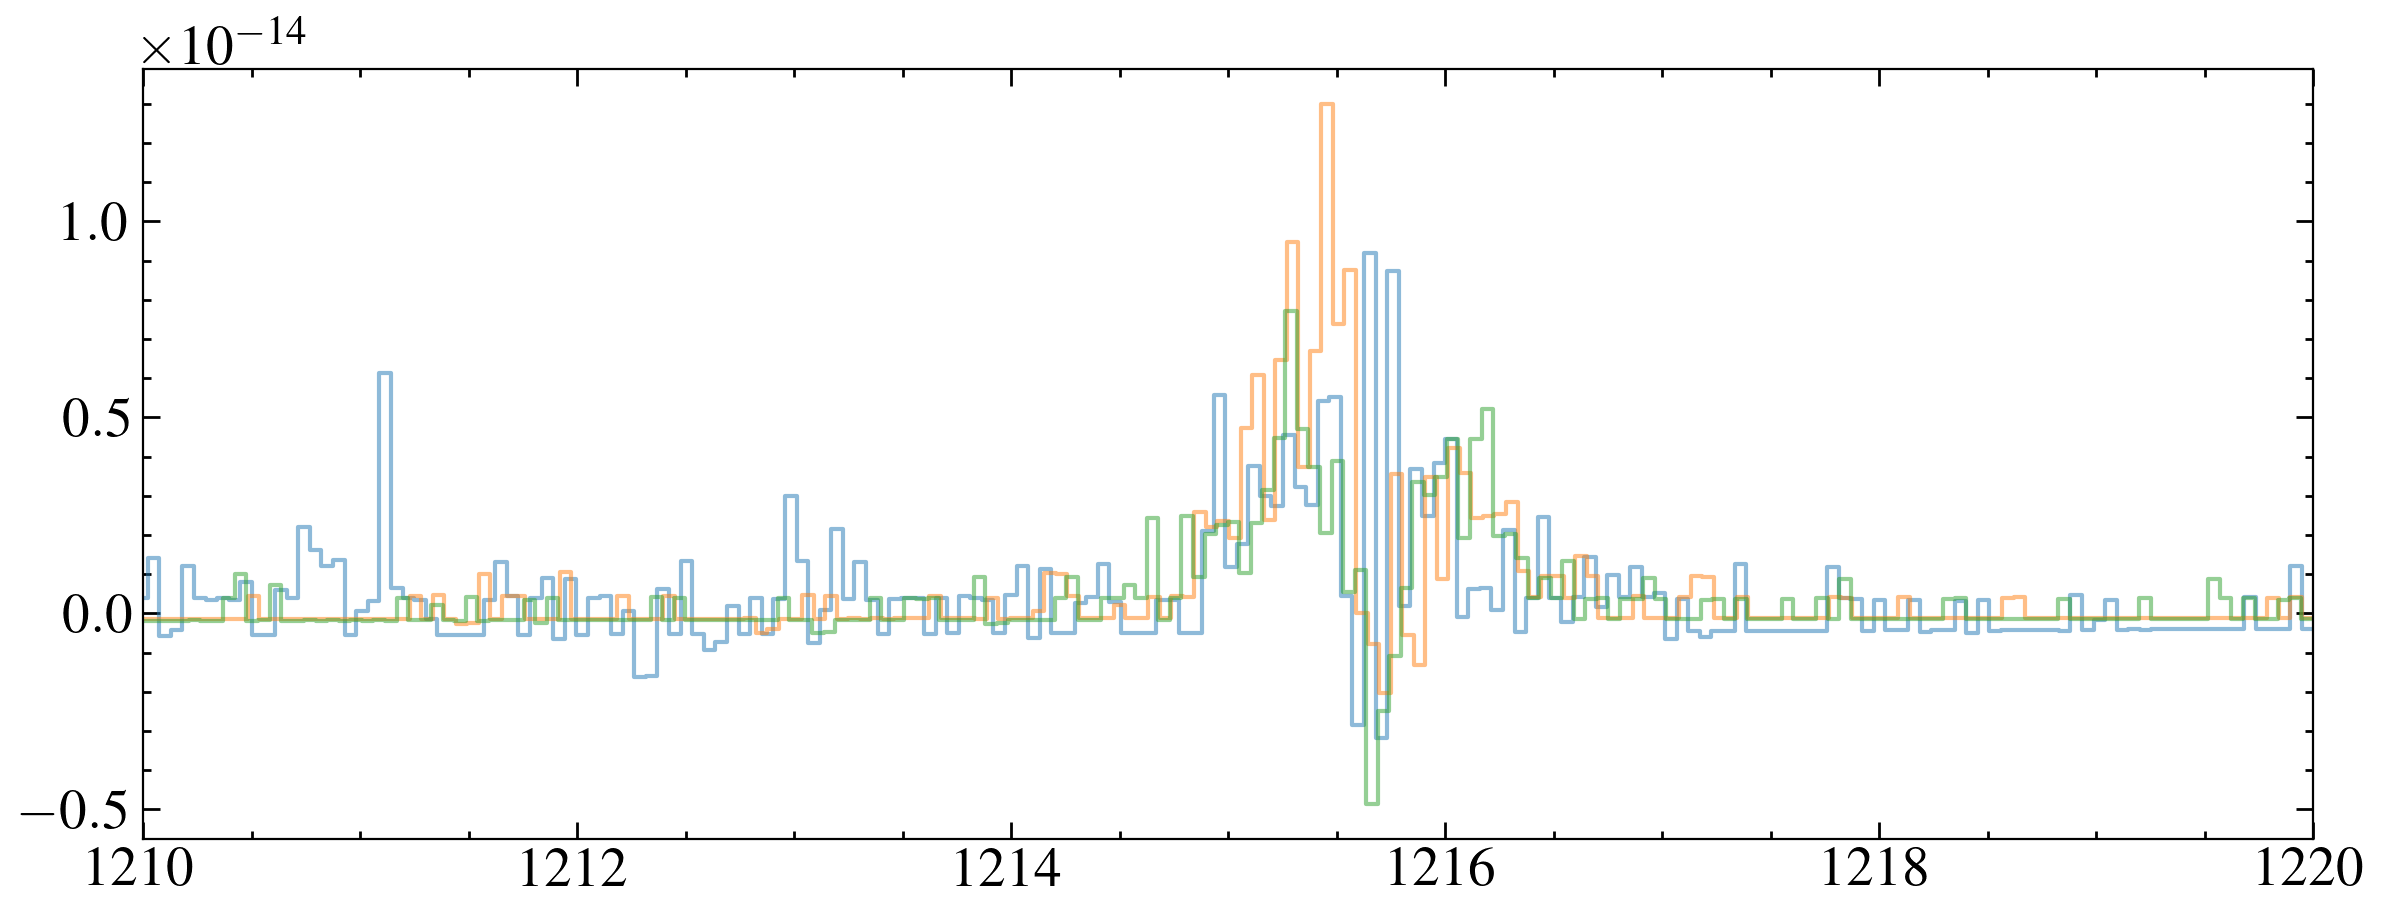

In [30]:
new_x1ds = glob.glob('{}use_spectra/*x1d.fits'.format(path))

fig,ax = plt.subplots()

for x in new_x1ds:
    print(x)
    grating = fits.getheader(x, 0)['OPT_ELEM'] 
    print(grating)
    data = fits.getdata(x, 1)[0]
    w, f, e= data['WAVELENGTH'], data['FLUX'], data['ERROR']
    if grating == 'G140M':
        # mask = w > 1600
        # w, f, e = w[mask], f[mask], e[mask]
        plt.step(w, f, where='mid', alpha =0.5)
    # plt.step(w, e, where='mid')
    # plt.show()
ax.set_xlim(1210, 1220)

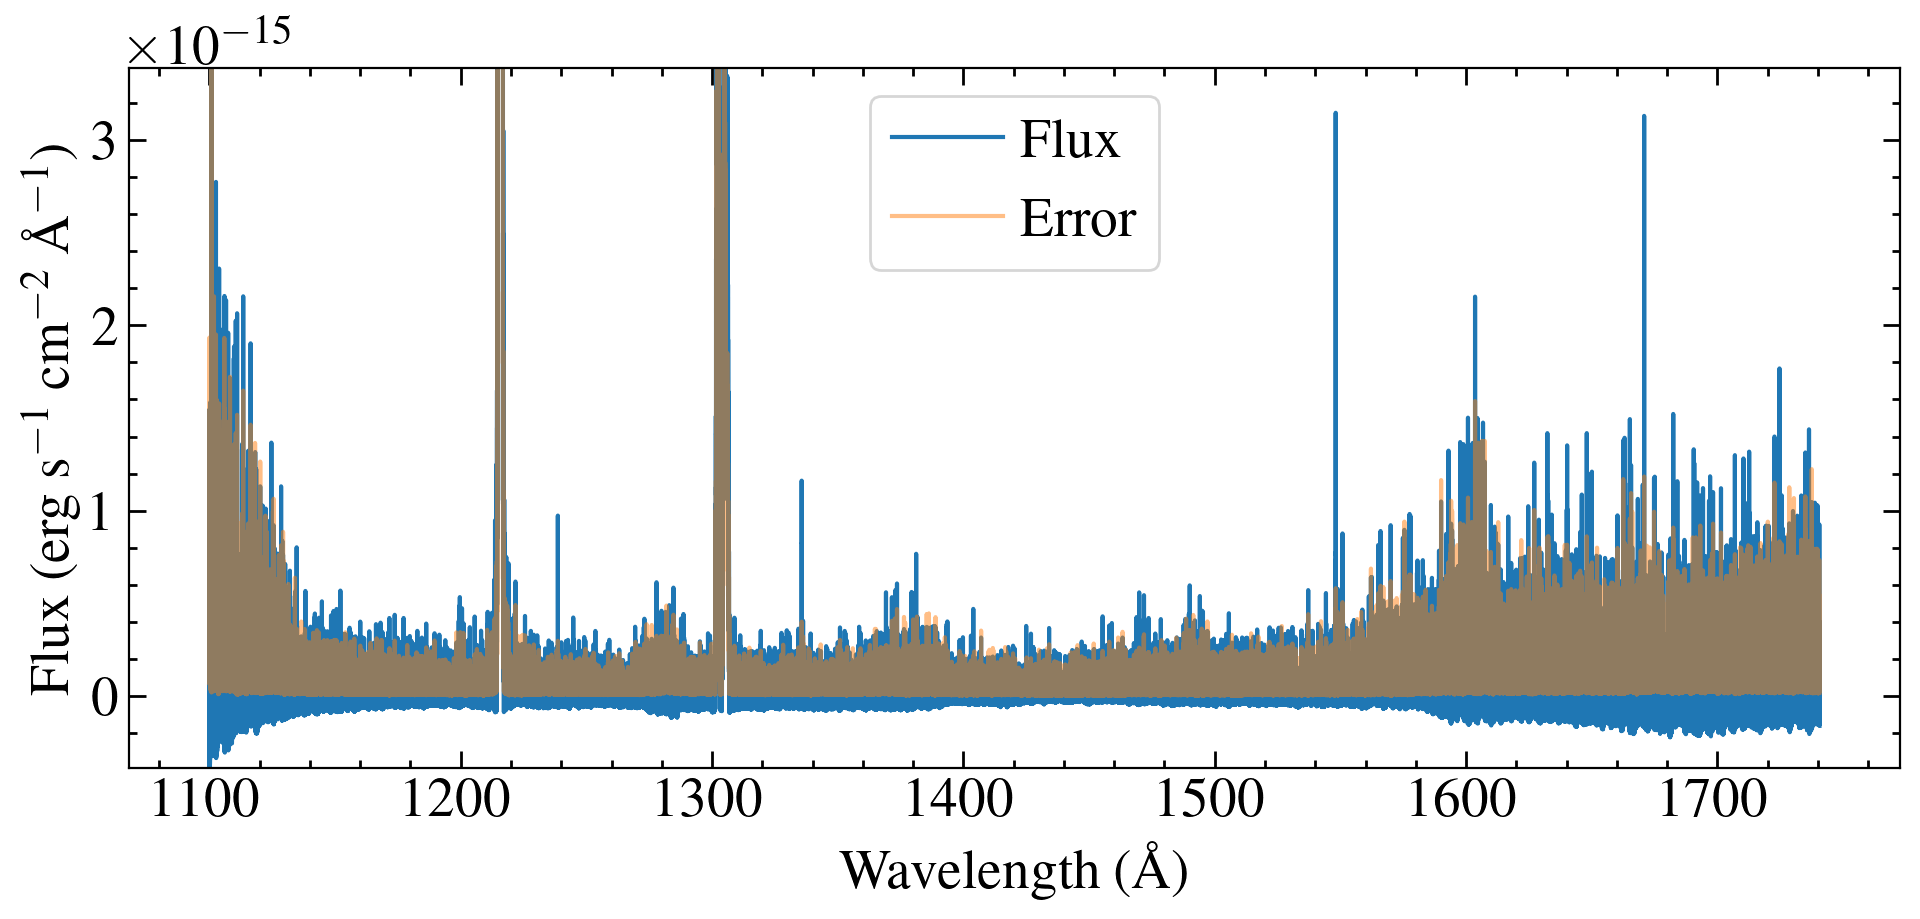

In [31]:
fig, ax = plt.subplots(figsize=(10, 5))

kw, kf, ke = np.loadtxt('cos_files/lhs_1140/LHS1140_COSM_Mm1_13sept2024.sav.txt', unpack = True, skiprows=2)
mask = kw > 1100
kw, kf, ke = kw[mask], kf[mask], ke[mask]
ax.step(kw, kf, where='mid', c='C0', label='Flux')
ax.step(kw, ke, where='mid', c='C1', alpha=0.5, label='Error')

# ax.set_xlim(1235.1, 1244.9)
ax.set_ylim(-0.39e-15, 3.39e-15)

ax.set_xlabel('Wavelength (\AA)')
ax.set_ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)')
ax.legend(frameon=True)
fig.tight_layout()

['/media/david/2tb_ext_hd/hddata/meats/hst/lhs_1140/cos/ldmw4c010_x1dsum.fits', '/media/david/2tb_ext_hd/hddata/meats/hst/lhs_1140/cos/ldmw4c020_x1dsum.fits', '/media/david/2tb_ext_hd/hddata/meats/hst/lhs_1140/cos/ldmw4c030_x1dsum.fits', '/media/david/2tb_ext_hd/hddata/meats/hst/lhs_1140/cos/ldmw1c010_x1dsum.fits', '/media/david/2tb_ext_hd/hddata/meats/hst/lhs_1140/cos/ldmw1c020_x1dsum.fits', '/media/david/2tb_ext_hd/hddata/meats/hst/lhs_1140/cos/ldmw1c030_x1dsum.fits', '/media/david/2tb_ext_hd/hddata/meats/hst/lhs_1140/cos/ldmw1c040_x1dsum.fits', '/media/david/2tb_ext_hd/hddata/meats/hst/lhs_1140/cos/ldmw4c040_x1dsum.fits', '/media/david/2tb_ext_hd/hddata/meats/hst/lhs_1140/cos/ldmw2c010_x1dsum.fits', '/media/david/2tb_ext_hd/hddata/meats/hst/lhs_1140/cos/ldmw2c020_x1dsum.fits', '/media/david/2tb_ext_hd/hddata/meats/hst/lhs_1140/cos/ldmw2c030_x1dsum.fits', '/media/david/2tb_ext_hd/hddata/meats/hst/lhs_1140/cos/ldmw2c040_x1dsum.fits', '/media/david/2tb_ext_hd/hddata/meats/hst/lhs_1140/

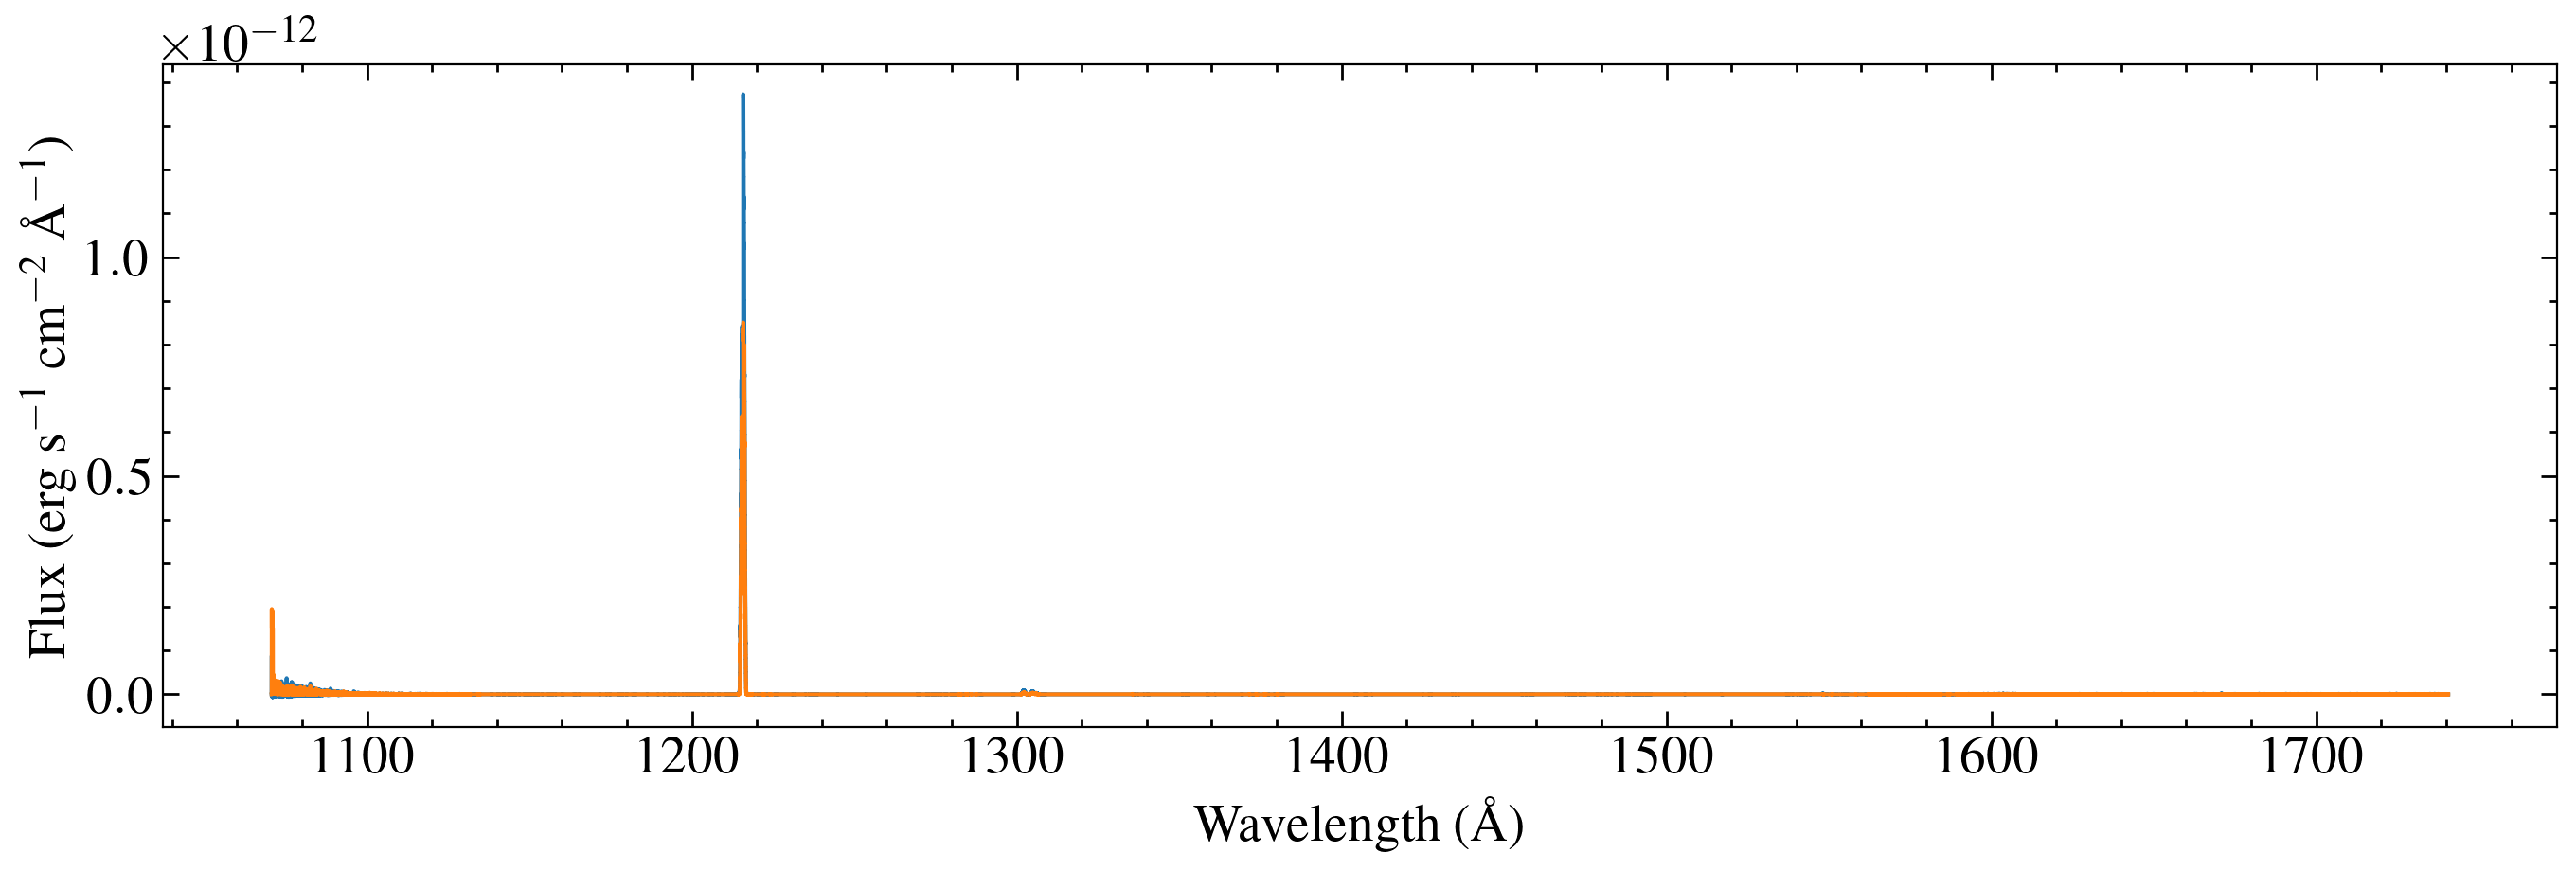

Spectrum saved as hlsp_muscles_hst_cos_lhs_1140_g130m_v1_component-spec.fits


In [32]:
import prepare_cos
# importlib.reload(prepare_cos)

savpath = 'cos_files/lhs_1140/LHS1140_COSM_Mm1_13sept2024.sav.txt'
x1dpath = '/media/david/2tb_ext_hd/hddata/meats/hst/lhs_1140/cos/'
hlsp = 'meats_hlsp_info.csv'
version = 1
savepath = 'draft_hlsp/lhs_1140/'
# star = 
prepare_cos.make_cos_spectrum(savpath, version, x1dpath, hlsp, savepath = savepath, plot=True, save_fits=True, star='LHS_1140')

In [33]:
import prepare_phoenix_svo as pp
# importlib.reload(pp)

#using https://ui.adsabs.harvard.edu/abs/2024ApJ...960L...3C/abstract

G = const.G
M = const.M_sun.to(u.kg)
R = const.R_sun.to(u.m)
mass = 0.1844
teff = 3096 
teff_e = 48

radius = 0.2159
distance = 14.9861

save_path = 'models/'
star = 'LHS_1140'
# g = ((G*mass*M)/(radius*R)**2).to(u.cm/u.s**2)
g = 5.041
repo = '/media/david/2tb_ext_hd/hddata/mega_muscles/data-vacuum/'

star_params = {'Teff': teff, 'Teff_e':teff_e,  'logg': g, 'FeH': 0.00, 'aM': 0, 'Radius':radius*u.R_sun, 'Distance':distance*u.pc}
# pw, pf, pe = pp.make_phoenix_spectrum(star, save_path, repo, star_params, save_ecsv=True, plot=True, make_error=True)
pdata = Table.read('models/{}_phoenix_interpolated.ecsv'.format(star))
pw, pf, pe = pdata['WAVELENGTH'], pdata['FLUX'], pdata['ERROR']
normfac = ((radius*R)/((distance*u.pc).to(u.m)))**2

In [34]:
import prepare_model
hdr = fits.getheader('draft_hlsp/lhs_1140/hlsp_muscles_hst_stis_lhs_1140_g140m_v1_component-spec.fits' , 0)
sed_data = Table(meta=hdr)

In [35]:
prepare_model.make_model_spectrum('models/LHS_1140_phoenix_interpolated.ecsv', 1, sed_data,
                                  savepath = savepath, save_ecsv=False, save_fits=True, normfac=normfac.value, model_name='PHX')

Spectrum saved as hlsp_muscles_model_phx_lhs_1140_na_v1_component-spec.fits


In [36]:
#comp with gaia

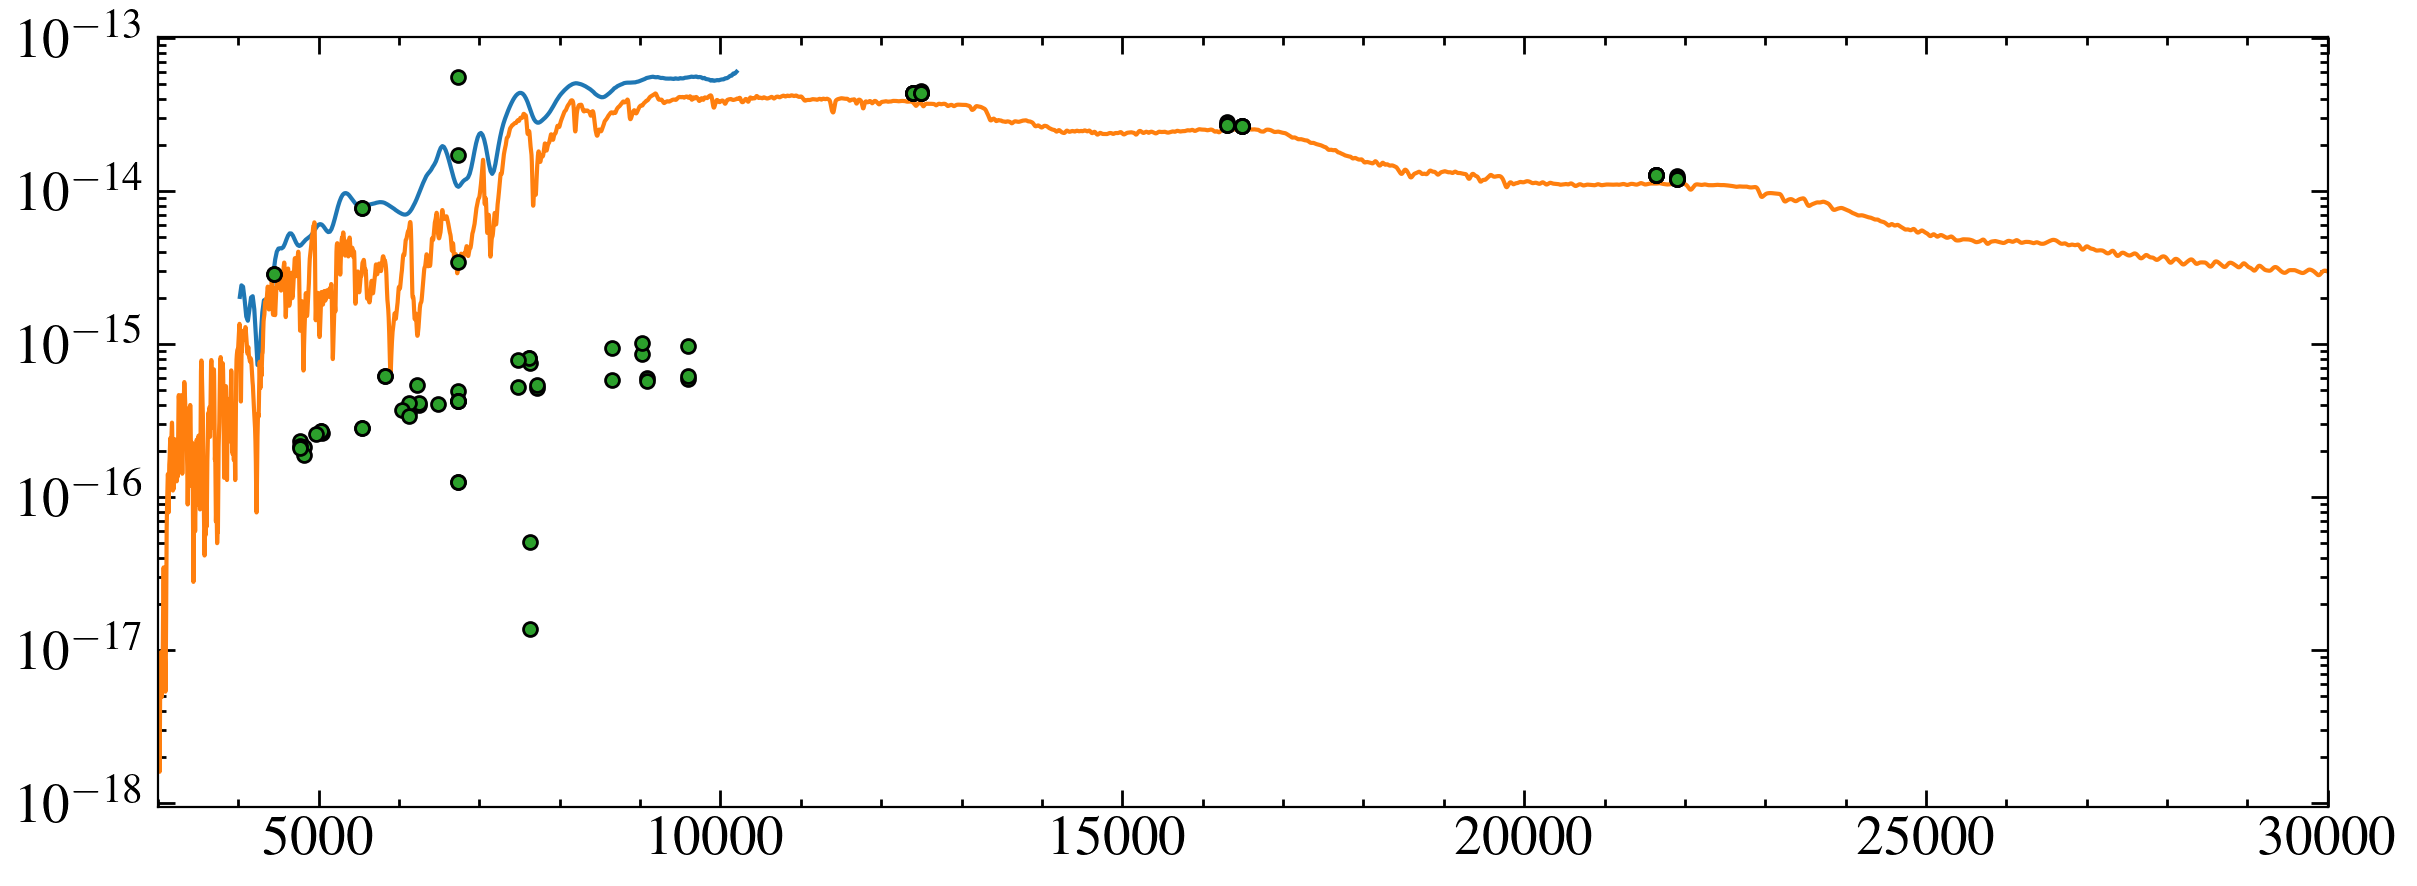

In [37]:
gaia = Table.read('misc_data/lhs_1140_gaia/gaiadr3_sampled_mean_spectra_2371032916186181760.vot')
mask = gaia['type'] == 'XP'
gw, gf = gaia['wavelength'][mask]*10, gaia['flux'][mask]*(u.W/u.m**2/u.nm).to(u.erg/u.s/u.cm**2/u.AA)
mask = (gw > 4000) #& (gw < 1000)
gw, gf = gw[mask], gf[mask]

pwi, pfi = pp.smear(pw, pf,1000)
pmask = (pwi > 3000) & (pwi < 30000)
pwi, pfi = pwi[pmask], pfi[pmask]*normfac


fig, ax = plt.subplots()

ax.plot(gw, gf)
ax.plot(pwi, pfi)


phot = Table.read('misc_data/lhs_1140.vot')
mask = (~phot['sed_eflux'].mask) & (phot['sed_eflux'] > 0) 
phot_w = (phot['sed_freq'][mask]).to(u.AA,  equivalencies=u.spectral())
phot_f = (phot['sed_flux'][mask]).to(u.erg/u.s/u.cm**2/u.AA,  equivalencies=u.spectral_density(phot_w))
phot_e =np.array(phot['sed_eflux'][mask])
phot_e = ((phot_e/phot['sed_flux'][mask]).value)*phot_f.value

mask = phot_f.value/phot_e > 10
# print(phot_e)
# print(phot_e)
ax.errorbar(phot_w[mask], phot_f[mask].value, yerr=phot_e[mask], ls='none', marker='o', ms=5, label = 'Photometry', markeredgecolor='k')

ax.set_xlim(3000, 30000)
ax.set_yscale('log')


Okaaaayyyy model seems ok, dunno what's up with Gaia. See what Allison gets for nH and redo Swift. Mesure lines in COS spectrum next

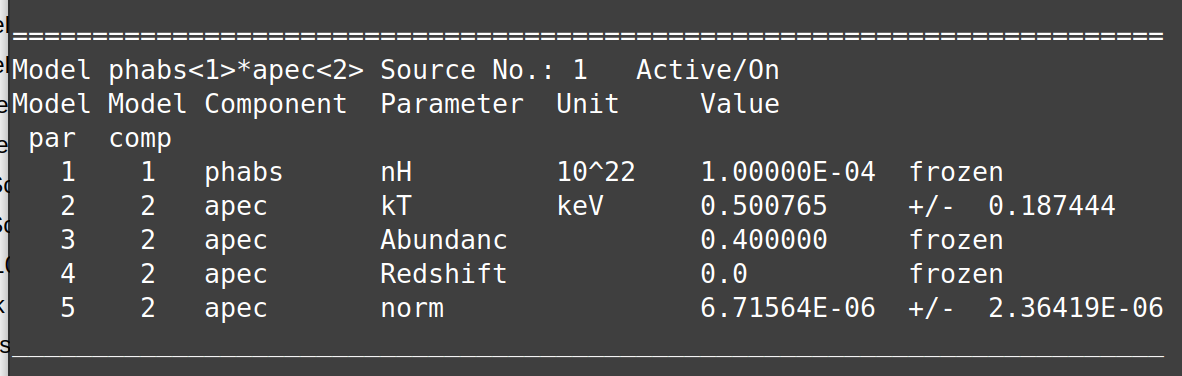

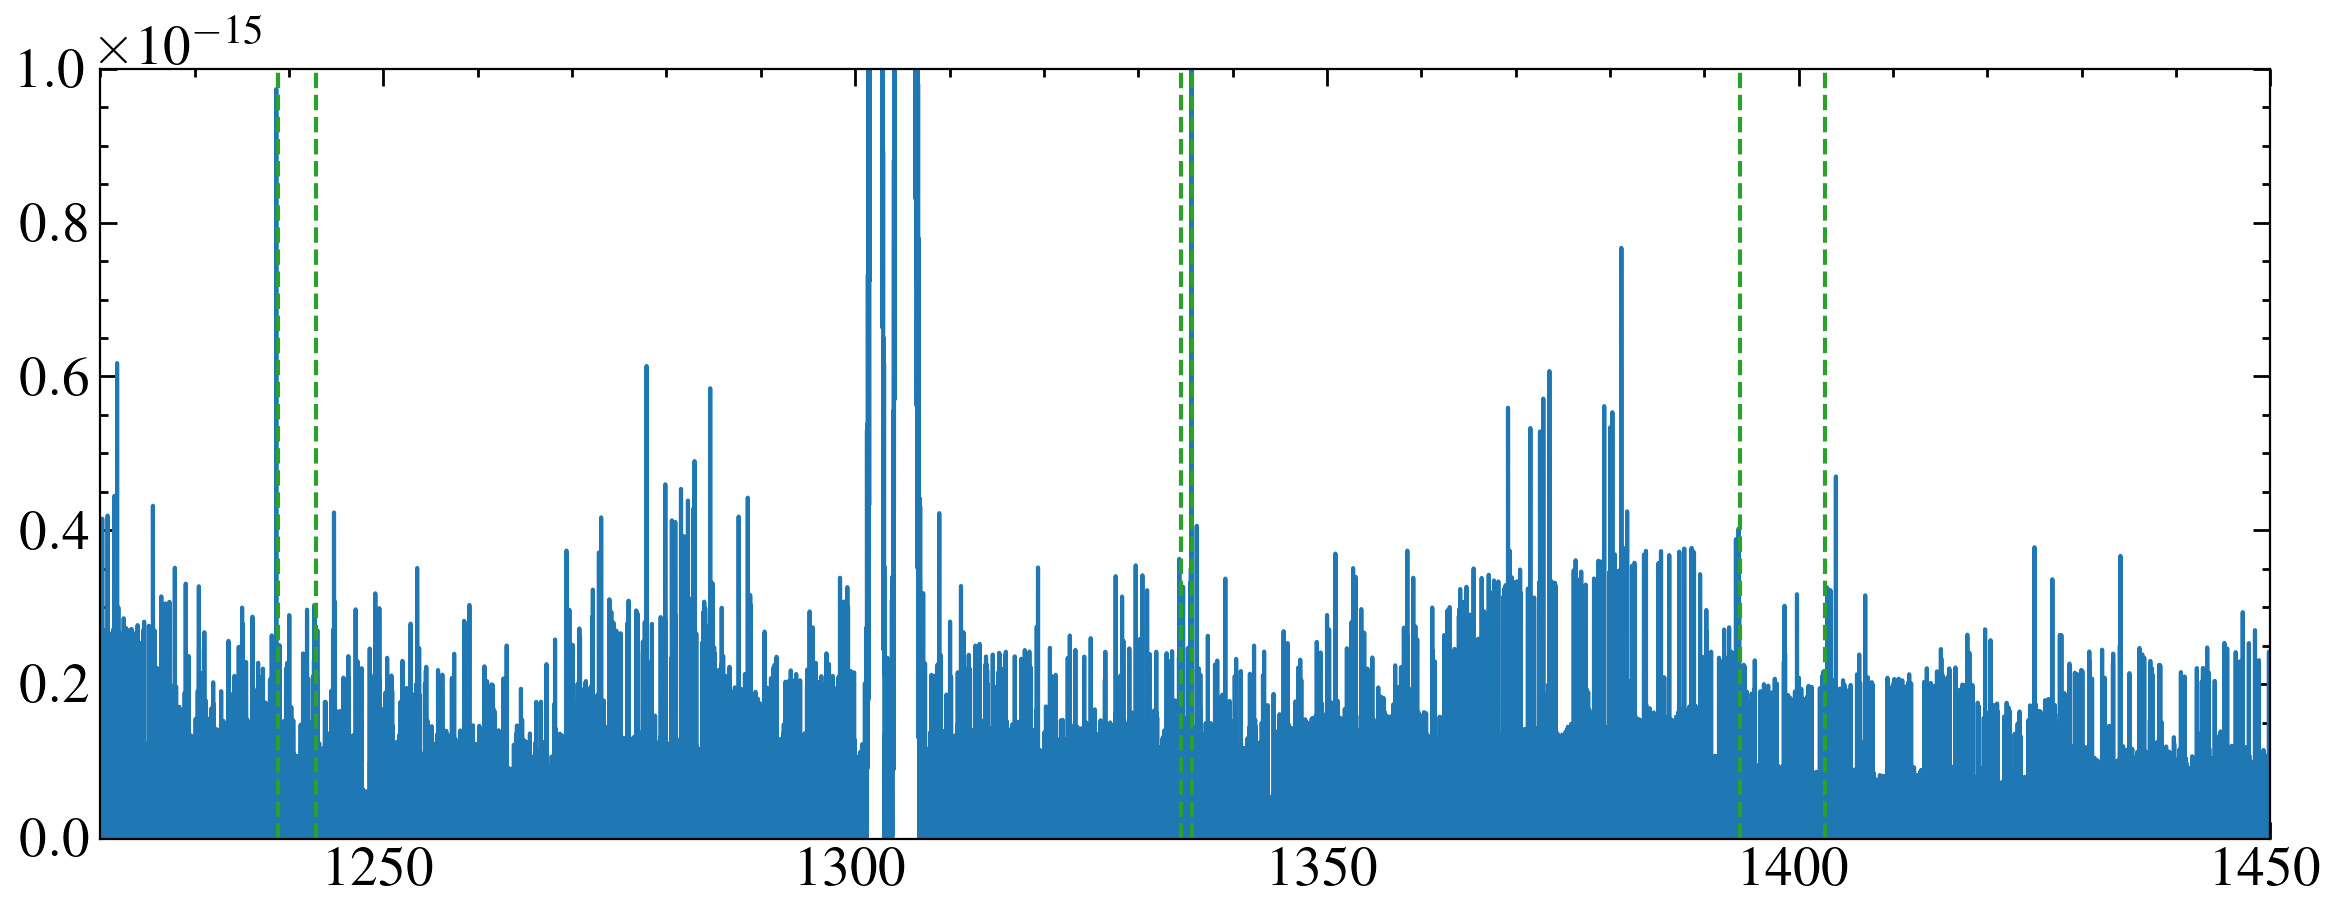

siiv 1.6184598743203156e-16 3.6436690114642676e-17


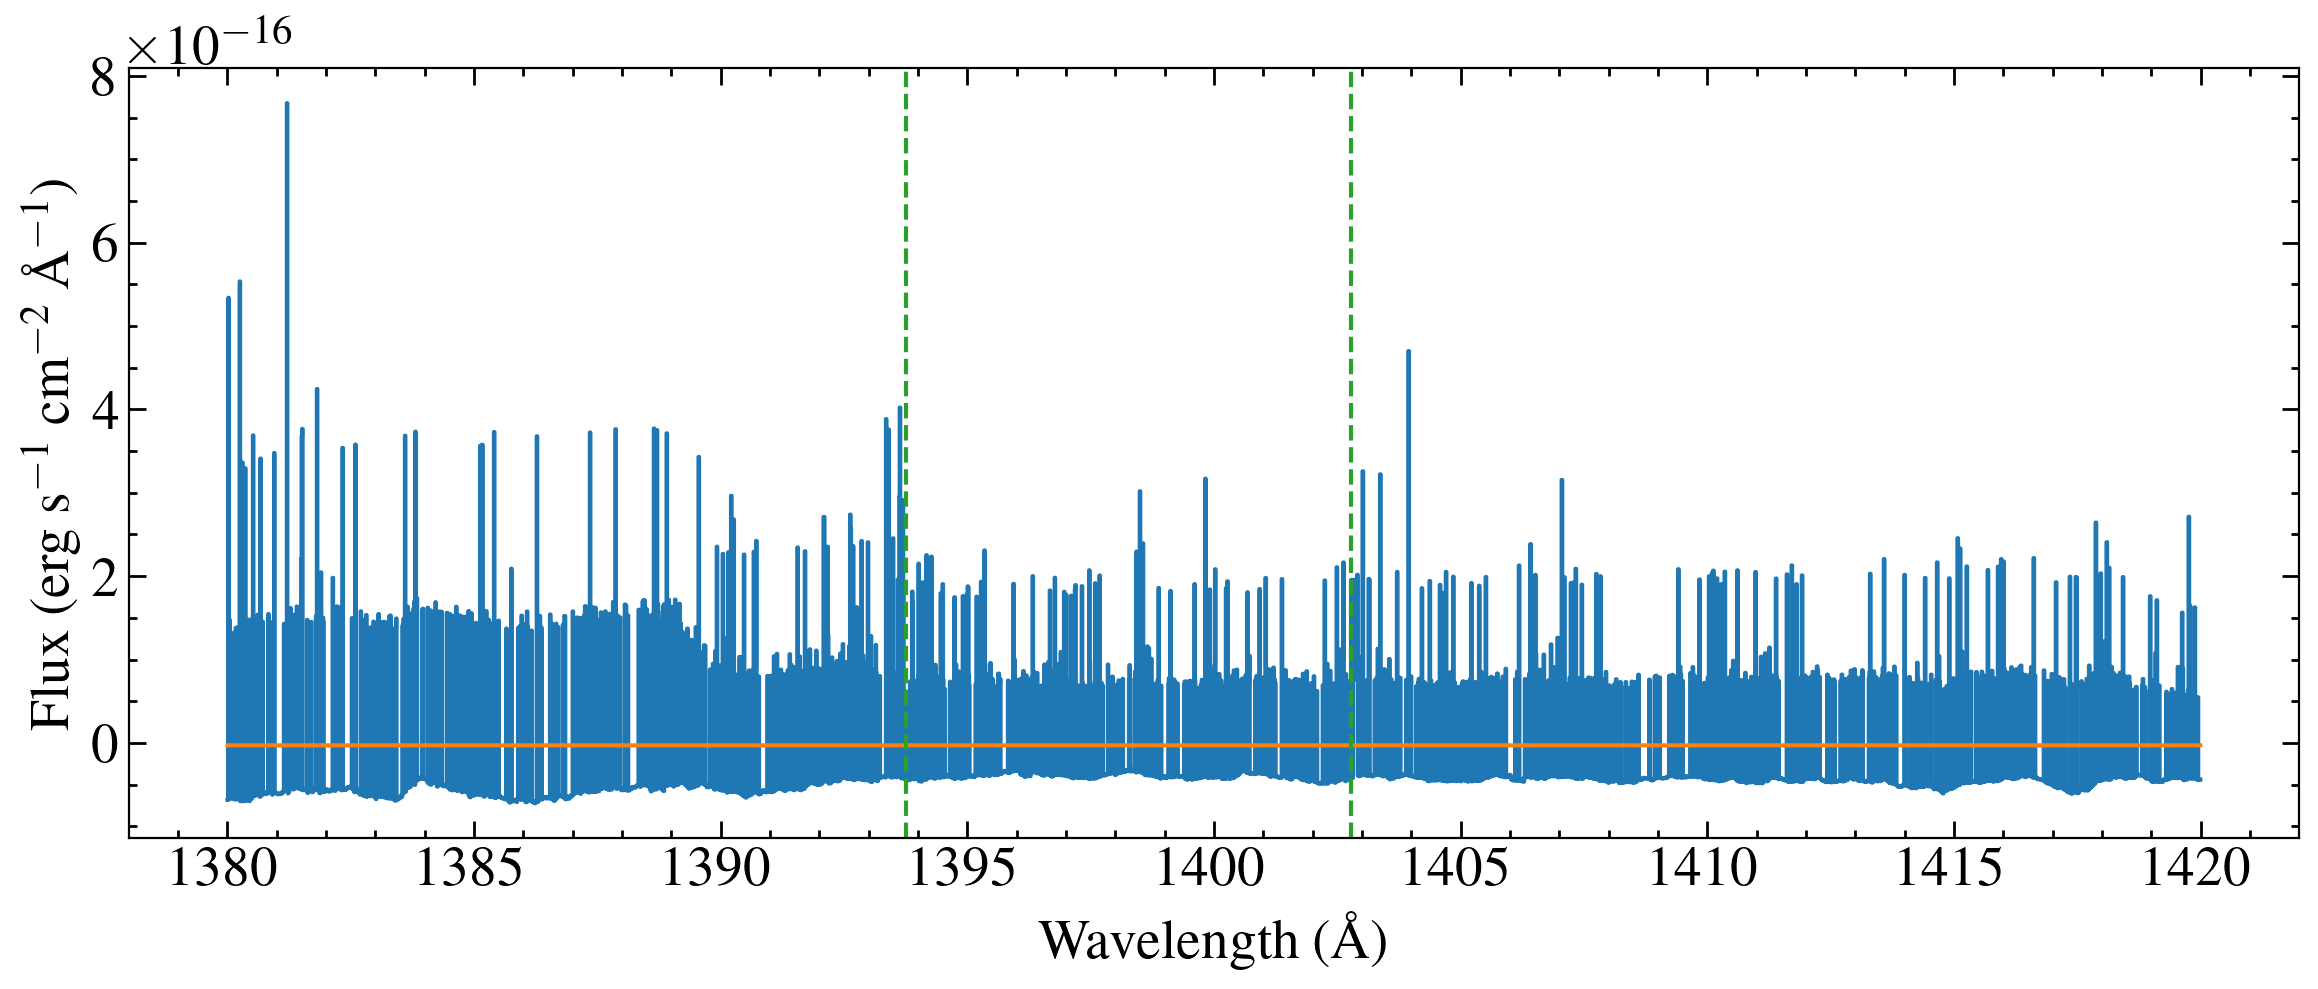

Model: Const1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
          amplitude       
    ----------------------
    -4.631237581637165e-18
{'residuals': array([4.63274871e-30]), 'rank': 1, 'singular_values': array([0.03325951]), 'params': array([-4.63123758e-18])}
nv 1.1376921766178111e-16 2.302711966395728e-17
Model: Const1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
          amplitude       
    ----------------------
    1.6284135528942104e-18
{'residuals': array([2.97566007e-30]), 'rank': 1, 'singular_values': array([0.04467671]), 'params': array([1.62841355e-18])}
803
c2 3.1402200022746226e-17 2.3862791355311246e-17


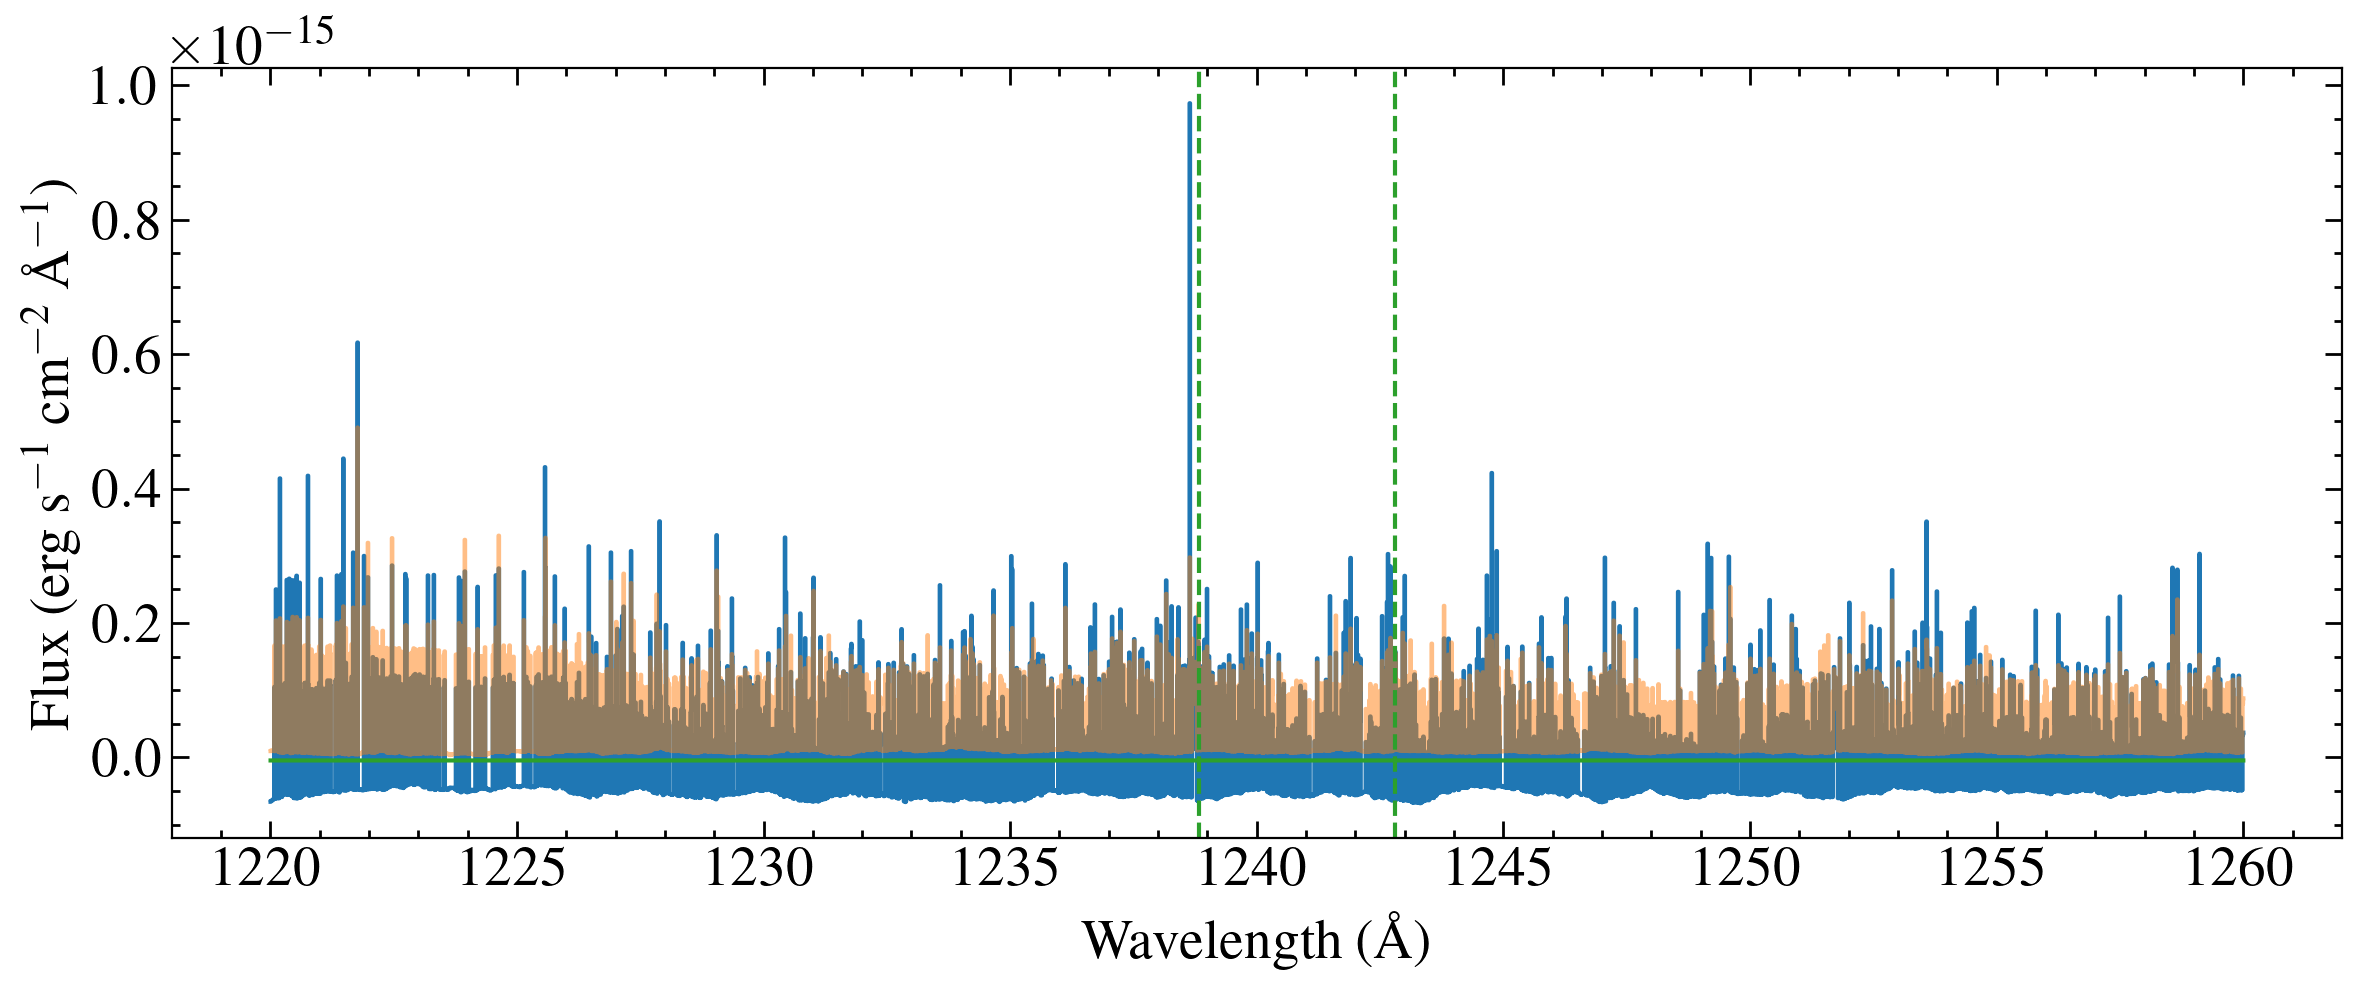

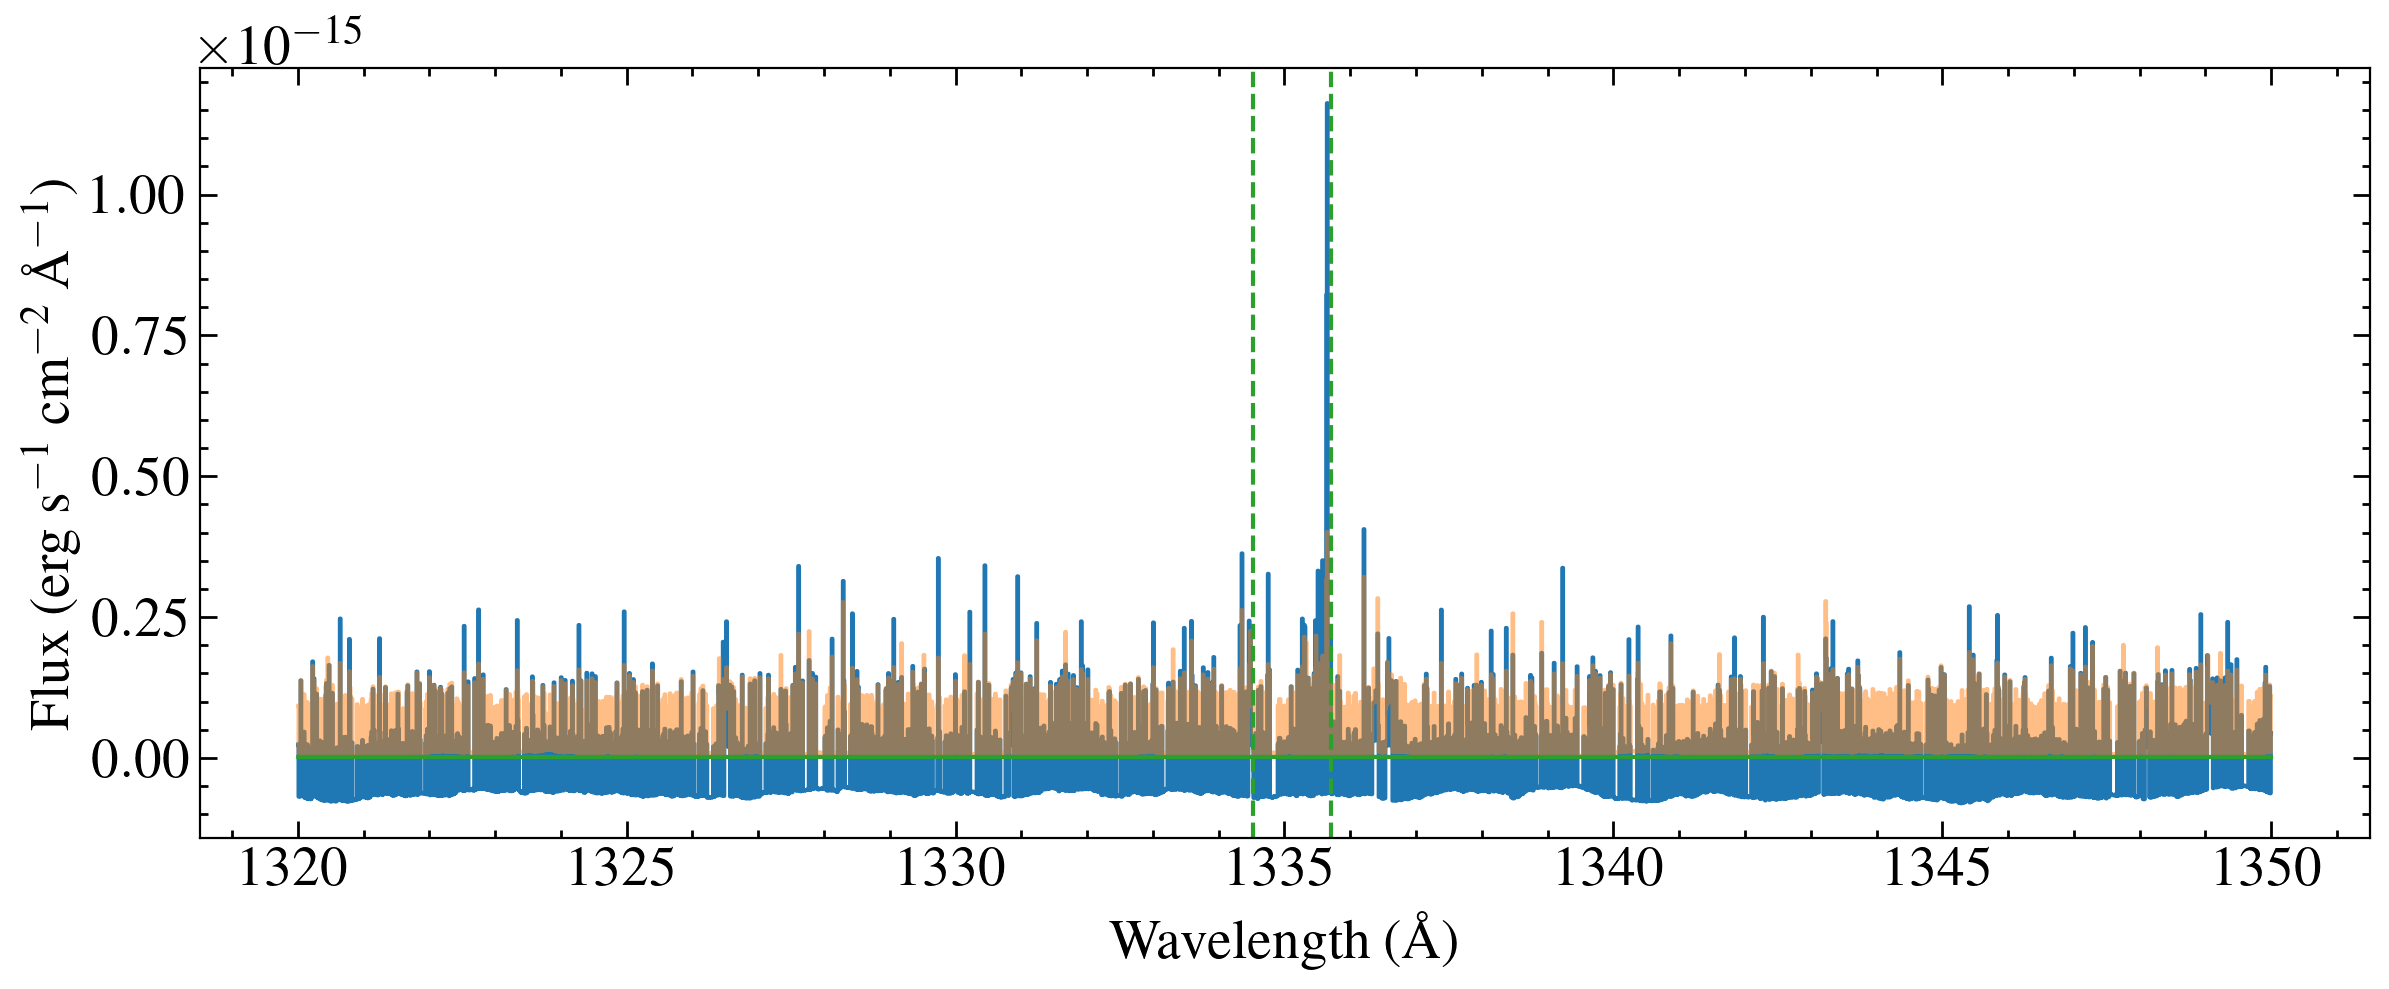

In [38]:



def wavelength_edges(w):
    """
    Calulates w0 and w1
    """
    diff = np.diff(w)
    diff0 = np.concatenate((np.array([diff[0]]), diff)) 
    diff1 = np.concatenate((diff, np.array([diff[-1]]))) 
    w0 = w - diff0/2.
    w1 = w + diff1/2.
    return w0, w1

n5 = [1238.821, 1242.804]
si4 = [1393.755,1402.77] 
c2 = [1334.524, 1335.709]

fig, ax = plt.subplots()

# data = fits.getdata(x1ds[0], 1)[0]
# w, f, e= data['WAVELENGTH'], data['FLUX'], data['ERROR']

# ax.step(hasp_spec['WAVELENGTH'], hasp_spec['FLUX'], where='mid')
ax.step(kw, kf, where='mid')
# ax.set_yscale('log')
# ax.set_xscale('log')
ax.set_xlim(1220, 1450)
ax.set_ylim(-1e-18, 1e-15)

[ax.axvline(line, ls='--', c='C2') for line in n5]
[ax.axvline(line, ls='--', c='C2') for line in si4]
[ax.axvline(line, ls='--', c='C2') for line in c2]

plt.show()


fig, ax = plt.subplots()

mask = (kw > 1380) & (kw < 1420) #& (kf >0)
wi, fi, ei = kw[mask], kf[mask], ke[mask] 

fi = np.nan_to_num(fi, 0)
ei = np.nan_to_num(ei, 0)

plt.step(wi, fi, where='mid')
plt.xlabel('Wavelength (\AA)')
plt.ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)')

fitter = fitting.LinearLSQFitter()

cont_mask = (wi > 1370) & (wi < 1390) | (wi > 1410) & (wi < 1430)
cont_mod = models.Const1D(0)
cont_fit = fitter(cont_mod, wi[cont_mask], fi[cont_mask])

ax.plot(wi, cont_fit(wi))
[ax.axvline(line, ls='--', c='C2') for line in si4]


line_mask = (wi > 1390) & (wi < 1410)
line_w, line_f, line_e = wi[line_mask], fi[line_mask], ei[line_mask]
w0, w1 = wavelength_edges(line_w)
fi = np.sum(line_f*(w1-w0))
ei = (np.sum(line_e**2 * (w1-w0)**2))**0.5
ci = np.sum(cont_fit(line_w)*(w1-w0))
# print(fi, ci)
line_flux = fi - ci
print('siiv', line_flux, ei)

# print(np.trapz(line_f, line_w))

si4_flux, si4_flux_err = line_flux, ei

plt.show()

#Look for NV anyway 

fig, ax = plt.subplots()

mask = (kw > 1220) & (kw < 1260)# & (kf >0)
wi, fi, ei = kw[mask], kf[mask], ke[mask] 

fi = np.nan_to_num(fi, 0)
ei = np.nan_to_num(ei, 0)

plt.step(wi, fi, where='mid')
plt.step(wi, ei, where='mid', alpha=0.5)
plt.xlabel('Wavelength (\AA)')
plt.ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)')

fitter = fitting.LinearLSQFitter()

cont_mask = (wi > 1232) & (wi < 1236) | (wi > 1245) & (wi < 1250)
cont_mod = models.Const1D(0)
cont_fit = fitter(cont_mod, wi[cont_mask], fi[cont_mask])
print(cont_fit)
print(fitter.fit_info)
# cont_fit_e = np.sqrt(np.diag(fitter.fit_info['param_cov']))


ax.plot(wi, cont_fit(wi))

line_mask = (wi > 1236) & (wi < 1245)
line_w, line_f, line_e = wi[line_mask], fi[line_mask], ei[line_mask]
w0, w1 = wavelength_edges(line_w)
fi = np.sum(line_f*(w1-w0))
ei = (np.sum(line_e**2 * (w1-w0)**2))**0.5
ci = np.sum(cont_fit(line_w)*(w1-w0))
# print(fi, ci)
line_flux = fi - ci
print('nv', line_flux, ei)
[ax.axvline(line, ls='--', c='C2') for line in n5]

# print(np.trapz(line_f, line_w))

n5_flux, n5_flux_err = line_flux, ei


#c2 
# c2 = 


fig, ax = plt.subplots()

mask = (kw > 1320) & (kw < 1350) #& (kf >0)
wi, fi, ei = kw[mask], kf[mask], ke[mask] 

fi = np.nan_to_num(fi, 0)
ei = np.nan_to_num(ei, 0)

plt.step(wi, fi, where='mid')
plt.step(wi, ei, where='mid', alpha=0.5)
plt.xlabel('Wavelength (\AA)')
plt.ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)')

fitter = fitting.LinearLSQFitter()

cont_mask = (wi > 1330) & (wi < 1332) | (wi > 1337) & (wi < 1340)
cont_mod = models.Const1D(0)
cont_fit = fitter(cont_mod, wi[cont_mask], fi[cont_mask])
print(cont_fit)
print(fitter.fit_info)
# cont_fit_e = np.sqrt(np.diag(fitter.fit_info['param_cov']))


ax.plot(wi, cont_fit(wi))

line_mask = (wi > 1332) & (wi < 1340)
line_w, line_f, line_e = wi[line_mask], fi[line_mask], ei[line_mask]
print(len(line_w))
w0, w1 = wavelength_edges(line_w)
fi = np.sum(line_f*(w1-w0))
ei = (np.sum(line_e**2 * (w1-w0)**2))**0.5
ci = np.sum(cont_fit(line_w)*(w1-w0))
# print(fi, ci)
line_flux = fi - ci
print('c2', line_flux, ei)
[ax.axvline(line, ls='--', c='C2') for line in c2]

# print(np.trapz(line_f, line_w))

c2_flux, c2_flux_err = line_flux, ei


Have to go after CII? Might have to fit with LSFs